# **One Tutorial to Understand All (M5-Forecasting)**
### Khởi tạo và import các thư viện cần thiết

In [ ]:
# thực hiện chuẩn hoá các thư viện liên quan, mục đích đảm bảo source code bên dưới hoạt động tốt trong trường hợp Colab liên tục cập nhật phiên bản mới.
!pip install pandas==1.1.3
!pip install pystan==2.19.1.1
!pip install fbprophet 

import numpy as np # khai báo sử dụng thư viên numpy, chuẩn bị triển khai các hàm tính toán trên vector
import pandas as pd # khai báo sử dụng thư viện pandas, phục vụ các hàm xử lý dữ liệu, thao tác trên IO
import matplotlib.pyplot as plt # khai báo thư viện matplotlib, phục vụ các hàm vẽ biểu đồ, trực quan hoá dữ liệu

import time # thư viện phuc vụ các hàm thời gian
import math # thư viện phục vụ các biểu thức toán học
import datetime # thư viện phục vụ các hàm liên quan ngày - tháng 

# khai báo các thư viện quản lý UI (giao diện người dùng)
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns # khai báo sử dụng thư viên seaborn, phục vụ các hàm vẽ biểu đồ trực quan hoá cho dữ liệu 
sns.set_style('whitegrid') # thiết lập thuộc tính mặc định cho toàn bộ kiểu dáng (style) cho toàn bộ các biểu đồ sẽ được vẽ

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools # khai báo sử dụng thư viện itertool để tối ưu hoá tốc độ xử lý các vòng lặp
from itertools import cycle
plt.style.use('seaborn') # thiết lập kiểu hiển thị (stylesheet) cho các biểu đồ được vẽ
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color']) # tạo ra 1 iterator (đối tượng vòng lặp) với các giá trị màu sắc, các giá trị này được dùng để quy định màu sắc cho các biểu đồ được vẽ bên dưới

# truy xuất thư mục /kaggle/input và đọc toàn bộ đường dẫn tập tin đang chứa trong thư mục này
# Lưu ý: do kích thước tập tin lớn, nên hosting này không thể lưu trữ các tập tin, các tập tin sẽ được đọc lên từ 1 hosting khác được mô tả trong đoạn mã chương trình tiếp theo

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing the Datasets

In [ ]:
# đọc nội dung dữ liệu từ tập tin chỉ định, dữ liệu sẽ được ghi trực tiếp vào bộ nhớ dưới dạng từ điển (dictonary)
sell_prices_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sell_prices.csv') # trả về kiểu dữ liệu DataFrame 
train_sales_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sales_train_validation.csv') # trả về kiểu dữ liệu DataFrame 
calendar_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/calendar.csv') # trả về kiểu dữ liệu DataFrame 
submission_file = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sample_submission.csv') # trả về kiểu dữ liệu DataFrame 

### Understanding the Datasets

In [ ]:
sell_prices_df.info() # xem thông tin ngắn gọn của 1 DataFrame, hoạt động này với mục đích kiểm tra để chắn chắn nội dung các tập tin đã được đọc và phân bổ vào đúng biến mong muốn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [ ]:
train_sales_df.info() # xem thông tin ngắn gọn của 1 DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [ ]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [ ]:
submission_file.info() # xem thông tin ngắn gọn của 1 DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60980 entries, 0 to 60979
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60980 non-null  object
 1   F1      60980 non-null  int64 
 2   F2      60980 non-null  int64 
 3   F3      60980 non-null  int64 
 4   F4      60980 non-null  int64 
 5   F5      60980 non-null  int64 
 6   F6      60980 non-null  int64 
 7   F7      60980 non-null  int64 
 8   F8      60980 non-null  int64 
 9   F9      60980 non-null  int64 
 10  F10     60980 non-null  int64 
 11  F11     60980 non-null  int64 
 12  F12     60980 non-null  int64 
 13  F13     60980 non-null  int64 
 14  F14     60980 non-null  int64 
 15  F15     60980 non-null  int64 
 16  F16     60980 non-null  int64 
 17  F17     60980 non-null  int64 
 18  F18     60980 non-null  int64 
 19  F19     60980 non-null  int64 
 20  F20     60980 non-null  int64 
 21  F21     60980 non-null  int64 
 22  F22     60980 non-null

Now that we have taken a look at the data provided and have a general understanding of the dataset, we can see various relationships between the stores, the specific products sold, the categories that the consumers are most interested in as well as the sale of items per specific locale. Sell_prices_df contains information along the store level of some 6 million entries while the train_sales_df has informaiton about some 30,000 different products.

Furthermore, the dataset in the calendar_df makes it possible to do a time series analysis of the products sold.

### EDA (Exploratory Data Analysis)

**Questions on Distribution of Product & Behavior Across Timeline**

Starting with the dataframe denoted by train_sales_df that has the item specific ('id'), locale specific ('store_id' , 'state_id') and sales days specific (d_1 to d_1913) information; let us first make necessary adjustments to separate the sales days so that analysis along item_id, store_id and dept_id can be more easily observed across sales days only.

In [ ]:
train_sales_df.head(3) # truy xuất dữ liệu 3 dòng đầu tiên của 1 DataFrame

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [ ]:
# từ nội dung dữ liệu train_sales_df, trích xuất các giá trị là tên cột bắt đầu với tiền tố d_, phân bổ toàn bộ gía trị này vào biến d_cols
d_cols = [c for c in train_sales_df.columns if 'd_' in c] 

# bổ sung thêm cột total_sales_all_days vào biến DataFrame train_sales_df, 
# giá trị được tính bằng tổng cộng (sum) của toàn bộ cột có tiền tố d_ (đã được phân bổ và lưu trữ trong biến d_cols) theo chiều ngang (trục X)
# chi tiết: giá trị mới bằng tổng cộng các cột d_x trên cùng 1 hàng
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1) 

# bổ sung thêm cột avg_sales_all_days vào biến DataFrame train_sales_df
# giá trị được tính bằng trung bình cộng của toàn bộ cột có tiền tố d_, theo trục X
# chi tiết: giá trị mới bằng trung bình cộng các cột d_x trên cùng 1 hàng
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)

# bổ sung thêm cột median_sales_all_days vào biến DataFrame train_sales_df
# giá trị được tính bằng giá trị trung tâm của toàn bộ cột có tiền tố d_, theo trục X
# chi tiết: giá trị mới bằng gía trị trung tâm các cột d_x trên cùng 1 hàng, 
# giá trị trung tâm = cần phải sắp xếp dãy giá trị theo chiều tăng dần, tìm ra số trung tâm lớn nhất, nếu kết quả bao gồm nhiều số thì giá trị trung tâm = trung bình cộng của các số tìm được
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

**Distribution of Product_ids Across Categories?**


In [ ]:
# thực hiện nhóm (group by) dữ liệu train_sales_df theo đơn vị cat_id để ĐẾM tổng cộng các dòng dữ liệu theo phân nhóm này
# đồng thời đặt lại tên cho cột dữ liệu mới tổng hợp = total_entries
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')

# thiết lập các giá trị khởi tạo, chuẩn bị vẽ biểu đồ, bao gồm
# tập dữ liệu được phân bổ từ biến df
# giá trị phân vùng thể hiện từ cột total_entries (thuộc tính được truy xuất biến df)
# tên phân vùng thể hiện từ cột cat_id
# giá trị màu sắc các phân vùng được lấy từ tập hợp px (là alias của thư viện plotly.express được khai báo đầu chương trình)
# kích thước biểu đồ (chiều dài, chiều cao)
# tiêu đề biểu đồ
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Distribution of Product_IDs Across Categories')

# vẽ biểu đồ Pie, biểu đồ này thể hiện tỷ lệ phân bổ Doanh Số Bán Hàng theo từng Danh mục hàng hoá (Category)
fig.show()

In [ ]:
# thực hiện nhóm (group by) dữ liệu train_sales_df theo đơn vị state_id để TÍNH tổng cộng (sum) các giá trị total_sales_all_day theo phân nhóm này
# cột dữ liệu mới được tổng hợp vẫn được giữ tên là total_sales_all_day
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()

# thiết lập các giá trị khởi tạo, chuẩn bị vẽ biểu đồ, bao gồm
# tập dữ liệu được phân bổ từ biến df
# giá trị phân vùng thể hiện từ cột total_sales_all_day (thuộc tính được truy xuất biến df)
# tên phân vùng thể hiện từ cột state_id
# giá trị màu sắc các phân vùng được lấy từ tập hợp px (là alias của thư viện plotly.express được khai báo đầu chương trình)
# kích thước biểu đồ (chiều dài, chiều cao)
# tiêu đề biểu đồ
fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Distribution of Total_Sales Across States')

# vẽ biểu đồ Pie, biểu đồ này thể hiện tỷ lệ phân bổ giá trị Doanh Số Bán Hàng theo từng Bang (State)
fig.show()

With respect to the total number of sales, it is evident once again that the number of items sold on total have the greatest contributing share in CA, followed by Texas and Wisconsin. Now is it the case with the total revenue generated as well? We'd find that out using the revenue dataframe



In [ ]:
# thực hiện nhóm (group by) dữ liệu train_sales_df theo đơn vị cat_id để ĐẾM tổng cộng các dòng dữ liệu theo phân nhóm này
# đồng thời đặt lại tên cho cột dữ liệu mới tổng hợp = total_entries
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')

# thực hiện nhóm (group by) dữ liệu train_sales_df theo MỘT CẶP đơn vị state_id - cat_id để đếm tổng cộng (sum) giá trị total_sales_all_day theo phân nhóm này
# cột dữ liệu mới được tổng hợp vẫn được giữ tên là total_sales_all_day
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

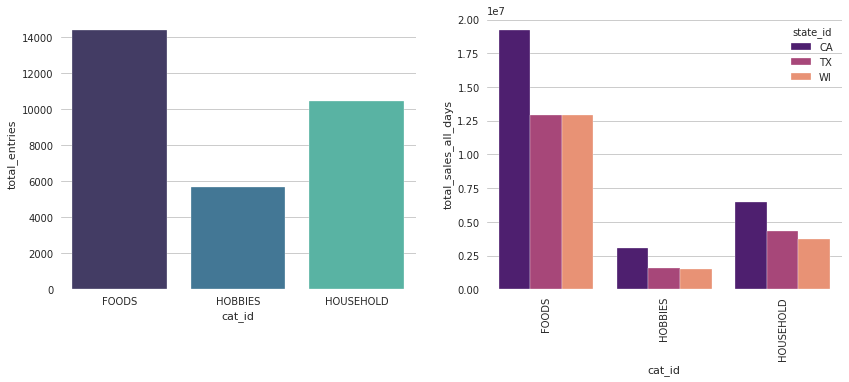

In [ ]:
sns.set_style('whitegrid') # thiết lập kiểu hiển thị (stylesheet) cho các biểu đồ được vẽ
sns.axes_style(style='ticks') # thiết lập kiểu hiển thị cho các đường line, ghi chú được thể hiện trong biểu đồ

# khởi tạo biến đối tượng Figure và bộ biến Axes chuẩn bị trực quan hoá dữ liệu 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

# thiết lập dữ liệu cho biểu đồ bao gồm
# đối tượng 01: phân bổ từ biến ax1 (được khởi tạo bên trên), trục X là giá trị cột cat_id, trục Y là giá trị total_entries, dữ liệu được load từ biến DataFrame df1
# đối tượng 02: phân bổ từ biến ax2, trục X là giá trị cột cat_id, trục Y là giá trị total_sales_all_days, dữ liệu được load từ biến DataFrame df2, màu sắc các gía trị trục X được phân vùng chi tiết theo state_id
sns.barplot(x = 'cat_id', y='total_entries', data=df1, palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, palette='magma', ax=ax2)

# thiết lập cách thức hiển thị ghi chú cho trục X, ghi chú thể hiện dưới 1 góc vuông 90 độ
plt.xticks(rotation=90)

# vẽ biểu đồ barchart, biểu đồ này thể hiện Doanh số bán hàng dưới dạng cột, theo các phân nhóm bao gồm
# đối tượng 01: Doanh số theo Danh mục sản phẩm (Category)
# đôí tượng 02: Doanh số theo Danh mục sản phẩm, chia nhỏ theo khu vực - Bang (State)
# dạng biểu đồ này cho phép ta thấy rõ tỷ trọng (Có thể so sánh) theo các phân vùng cụ thể
plt.show()

The above two plots indicate:


*   Most items sold belong to the FOODS category, followed by HOUSEHOLD and HOBBIES
*   CA leads in the number of "Total items" sold in either category (FOODS, HOBBIES AND HOUSEHOLD) , while WISCONSIN lags behind TX in each category except FOODS. We would see whether the same difference translates in terms of revenue extracted off these states or not

In [ ]:
# thực hiện nhóm (group by) dữ liệu train_sales_df theo MỘT CẶP đơn vị cat_id - state_id để ĐẾM tổng cộng các dòng dữ liệu theo phân nhóm này
# đồng thời đặt lại tên cho cột dữ liệu mới tổng hợp = num_sales_by_category
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')

# thiết lập giá trị chuẩn bị vẽ biểu đồ với thư viện ploty, bao gồm
# tập dữ liệu được phân bổ từ biến df (đã được tổng hợp bên trên)
# trục X thể hiện giá trị cột state_id
# trục Y thể hiện giá trị cột dữ liệu mới tổng hợp num_sales_by_category
# màu sắc phân bổ theo giá trị cột cat_id
# tiêu đề
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Distribution of Product_ids Count Across Categories & Each Locale")

# Vẽ biểu đồ, biểu đồ này cũng cho ta thấy phân bổ (có thể so sánh) của Doanh Số Bán Hàng được phân nhóm theo Khu vực - Bang (State), chia nhỏ rõ ràng theo Danh mục sản phẩm (Category)
fig.show()

A couple of points that could be drawn from this observation are:

* most items have been sold in california
* Texas and Wisconsin stores have almost total sales i.e. during the same timeframe of 1913 days, same number of items had been sold in both Texas and Wisconsin. Would this observation hold true in the sell_prices_df (revenue dataset) ? Does the observation remain same across different store locations in both Texas and Wisonconsin?

**Distribution of Items Across Department & Store_ids?**

In [ ]:
# thực hiện phân nhóm (group by) dữ liệu theo BỘ 4 cột dept_id - store_id - state_id - cat_id
# từ cột thứ 6 trở đi (theo khảo sát là các cột có tiền tố d_x và các cột dữ liệu tổng hợp total_sales, avg_sales, median_sales) được tổng hợp bằng TÍNH tổng cộng các cột cùng tên trong cùng phân nhóm 
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[6:]].sum().reset_index()

# sắp xếp bộ dữ liệu theo giá trị TĂNG DẦN của cột total_sales_all_days
df = df.sort_values('total_sales_all_days', ascending=False)

In [ ]:
x_dept = df['dept_id'] # phân bổ toàn bộ giá trị cột dữ liệu dept_id vào biến x_dept
x_store = df['store_id'] # phân bổ toàn bộ giá trị cột dữ liệu store_id vào biến x_store

# định nghĩa phương thức vẽ biểu đồ dạng barchart, thể hiện Doanh số bán hàng theo đơn vị ngày (danh sách này được định nghĩa qua biến cols bên trong thân hàm)
# x_specs: đơn vị thực hiện phân nhóm để tổng hợp Doanh số bán hàng theo đơn vị ngày 
# title_text: tiêu đề của biểu đồ
# title: tiêu đề đơn vị chọn lựa phân nhóm (theo từng Cửa Hàng - Store / từng tiểu Bang - State)
def items_sold_per_days(x_spec,title_text, title):
    
    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier
    
    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown), 
            title (title of the plot)
            
    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific 
    number of days        
    '''
    
    # biến quy định đơn vị ngày được sử dụng để tổng hợp dữ liệu > các lựa chọn (options) này chính là các col name trong danh sách dữ liệu từ biến train_sales_df
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']

    # định nghĩa đối tượng thể hiện dropdown list thể hiện các option được phân bổ từ biến cols
    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]

    # khởi tạo biến đối tượng Figure
    fig = go.Figure()
    # thiết lập các giá trị thuộc tính cho đối tượng fig, bao gồm loại biểu đồ sẽ được thể hiện, đồng thời thiết lập thuộc tính biểu đồ, bao gồm
    # trục X : được phân bổ dữ liệu bởi biến x_specs
    # trục Y : được phân bổ giá trị từ cột df[d_1] > đây cũng chính là lựa chọn (option) mặc định của dropdownlist được định nghĩa từ biến button1
    # tên và màu sắc thể hiện 
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))

    # thiết lập các thuộc tính thể hiện biểu đồ, bao gồm
    # tiêu đề hiển thị, được gán bằng biến title_text là tham số của đầu hàm
    # vị trí hiển thi của tiêu đề, giá trị 0.4 được hiểu là khoảng cách tính từ lề trái của tiêu đề
    # kích thước vùng thể hiện biểu đồ, chiều dài = 750, chiều rộng = 450
    # canh lề của vùng dữ liệu thể hiện, lề trên = 100, lề dưới = 20, lề trái = 0, lề phải = 0
    # không cho phép co giãn biểu đồ với thuộc tính autosize = false 
    # thiết lập thuộc tính của menu, với 1 dropdownlist được định nghĩa sẵn qua biến button, bao gồm:
    ### active: index của lựa chọn (options) đuọc lấy làm mặc định cho bộ lọc (filter)
    ### buttons: đối tượng thể hiện dropdownlist
    ### x,y : canh lề của đối bộ lọc (tính từ lề trái)
    ### xanchor, yanchor : vị trí hiển thị của bộ lọc (bên trái, trên cùng)  
    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 

    # thiết lập các thuộc tính ghi chú cho biểu đồ, bao gồm
    # x,y : vị trí hiển thị của ghi chú trên X, Y 
    # showarrow: thiết lập cách thức hiển thị của các ghi chú có bao gồm kí tự phân cách \ hay không, giá trị False cho phép ghi chú thể hiện theo định dạnh người dùng quy định (bởi biến text)
    # xref, yref: thiết lập gía trị toạ độ trên trục X, Y, gía trị paper cho phép giá trị toạ độ X, Y bắt đầu từ 0
    # xanchor : canh lề toàn bộ vùng thể hiện dữ liệu trên biểu đồ, giá trị left cho phép toàn bộ khu vực hiển thị dữ liệu canh lề từ bên trái 
    # title : định dạng tiêu đề bộ lọc được hiển thị, chu ý là giá trị biến này chỉ được áp dụng khi showarrow=False
    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));

    # Vẽ biểu đồ, biểu đồ này cho ta thấy Doanh Số Bán Hàng theo từng ngày (được chọn lựa từ dropdownlist)               
    fig.show()

# thể hiện biểu đồ Doanh Số Bán Hàng theo ngày (với template được định nghĩa từ hàm items_sold_per_days, bao gồm bộ lọc theo các ngày được xác định bên trong thân hàm )
# tập dữ liệu được dùng để thống kê đã được phân nhóm và tổng hợp theo bộ dept_id - store_id - state_id - cat_id
# thể hiện này cho phép ta có cái nhìn chi tiết hơn cho bộ dữ liệu df, Doanh số bán hàng theo ngày, tính trên đơn vị từng Cửa Hàng
items_sold_per_days(df['store_id'], 'Distribution of Sales Made on Each Store', 'Stores')

# thể hiện Doanh số bán hàng theo ngày, tính trên đơn vị từng tiểu Bang - State
items_sold_per_days(df['state_id'], "Distribution of Sales Made In Each State", 'States')

The data_analysis on these points helps make it clear that:

* Regarding the distribution of sales across department ids, most sales have been made across "FOODS_3" category followed by most sales made across household_1 category
* Stores locale identity along with embedded state_ids helpe make it clear that the distribution of sales across Texas & Wisconsin stores are NOT the same , though the total number represented across categories (foods, houshold and hobbies) might have come the same.
* The outperformers in Each state of CA, TX and Wisonsin are the stores with ids CA_3, TX_2 and WI_3 respectively


**Specific Item OutSelling the Most?**

Since the train_sales_df contains the information about each specific item and the number of sales made, we can make a few observations regarding the most frequently purchased item too.

We could plot its behavior across the number of days to get a general gist of its sales pattern across given days. i.e d_1 to d_1913



In [ ]:
# thực hiện thống kê dữ liệu, gom nhóm theo ID sản phẩm, tính lại tổng cộng Doanh Số bán hàng và sắp xếp dữ liệu theo hướng giảm dần
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_057_WI_2_validation            16
FOODS_2_071_TX_3_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

Once the total number of sales have been grouped against specific item id i.e. 'id' parameter, it is clear that the item **"FOODS_3_090_CA_3_validation"** has clearly sold most units than any other item in the category followed by **"FOODS_3_586_TX_2_validation"**. i.e. the first item belongs to food_3 category and sold in the CA_3 store location. Similarly, the second one belongs to TX_2 store location (i.e. second store in Texas) also belonging to the same category of FOODS_3 which is also consistent with observations made before

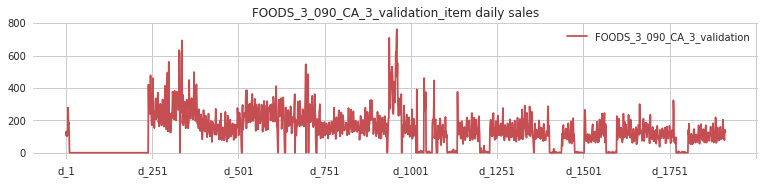

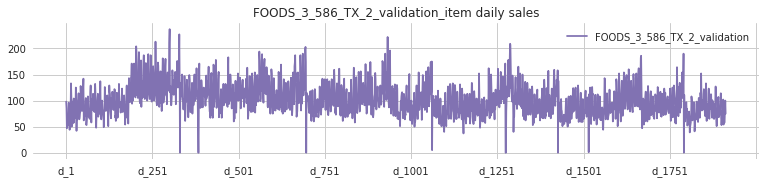

In [ ]:
sns.set_style('whitegrid') # thiết lập thuộc tính mặc định cho toàn bộ kiểu dáng (style) cho toàn bộ các biểu đồ sẽ được vẽ

# triển khai hàm vẽ biểu đồ thể hiện xu hướng phát triển của 1 đơn vị dữ liệu
# đầu vào là định danh (ID) của đơn vị dữ liệu muốn thể hiện
def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    # với định danh (ID) được truyền từ biến specs_id, truy xuất toàn bộ tập dữ liệu với ID này qua hàm .loc[]
    # đánh index cho toàn bộ cột có tên trong danh sách dữ liệu từ biến d_cols qua hàm set_index
    ### (remind) biến d_cols bao gồm danh sách các tên cột có tiền tố d_ được khởi tạo từ đầu chương trình
    # chuyển đổi dạng hiển thị của tập dữ liệu theo đường chéo, cụ thể là biến cột > dòng, dòng > cột qua hàm .T (chuẩn bị phân bổ vào thiết lập biểu đồ)
    # thiết lập cấu hình biểu đồ, bao gồm:
    ### figsize: kích thước dài x rộng (tính theo đơn vị inches)
    ### title : tiêu đề hiển thị
    ### color: được luân chuyển về giá trị kế tiếp của biến color_cyle được định nghĩa đầu chương trình
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    # thiết lập khu vực hiển thị dữ liệu
    plt.legend()
    # vẽ biểu đồ, biểu đồ này cho ta thấy xu hướng phát triển của đơn vị dữ liệu được lựa chọn theo từng ngày
    plt.show()

# thể hiện biểu đồ xu hướng với mã sản phẩm = FOODS_3_090_CA_3_validation
plot_dailysales('FOODS_3_090_CA_3_validation') 

# thể hiện biểu đồ xu hướng với mã sản phẩm = FOODS_3_586_TX_2_validation
plot_dailysales('FOODS_3_586_TX_2_validation')

**Item ID Outselling Most in Each Category?**

In [ ]:
# thống kê dữ liệu theo phân nhóm id - cat_id - store_id, tổng hợp dữ liệu total_sales_all_days theo tổng cộng phân nhóm này
# sắp xếp dữ liệu theo chiều giảm dần > mục đích tìm ra top các sản phẩm bán chạy nhất 
# gán tập dữ liệu đã qua thống kê vào biến df_agg
df_agg = pd.DataFrame(train_sales_df.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days'].sum().sort_values(ascending=False))

# tái thiết lập chỉ mục (index) cho tập dữ liệu sau khi thực hiện thống kê > điều này giúp đảm bảo hiệu quả truy xuất dữ liệu những lần kế tiếp 
df_agg = df_agg.reset_index()
df_agg.head(3)

,id,cat_id,store_id,total_sales_all_days
0,FOODS_3_090_CA_3_validation,FOODS,CA_3,250502
1,FOODS_3_586_TX_2_validation,FOODS,TX_2,192835
2,FOODS_3_586_TX_3_validation,FOODS,TX_3,150122


Now that the dataset has been arranged in descending order of total sales, it would be a lot easier to estimate the item_id ('id') outselling others in each category



In [ ]:
# tìm và in ra màn hình top 3 sản phẩm bán chạy nhất dựa vào gía trị cat_id
# [:3] thể hiện kết quả được tách từ đầu cho đến vị trí thứ 3
print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_118_CA_3_validation', 'HOUSEHOLD_1_459_CA_3_validation', 'HOUSEHOLD_1_334_CA_3_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_1_234_CA_3_validation', 'HOBBIES_1_348_CA_1_validation', 'HOBBIES_1_371_CA_1_validation']


In [ ]:
#df = pd.DataFrame({"days": list(train_sales_df[train_sales_df['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].columns),
#                   "sales_data": list(train_sales_df[train_sales_df['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].values.flatten())})

In [ ]:
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales_all_days,avg_sales_all_days,median_sales_all_days
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,3,0,1,1,600,0.313643,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,493,0.257710,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,1,1,288,0.150549,0.0


In [ ]:
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

# định nghĩa hàm vẽ biểu đồ dạng điểm (dot), biểu đồ này cho ta thấy doanh số bán hàng của từng mã định danh (ID) sản phẩm theo từng ngày
# dạng thể hiện này cho ta cái nhìn về mật độ phát triển của doanh số bán hàng trong từng khoảng thời gian trên trục X, từ đó có chiến lược đầu từ hàng hoá đầu vào tốt hơn trong từng khoảng thời điểm cụ thể
# specs_id: mã định danh (ID) đơn vị dữ liệu muốn khảo sát
# sm_start: giá trị ngày bắt đầu
# sm_end: gía trị ngày kết thúc (2 biến này sẽ được sử dụng để trích xuất giá trị từ các cột d_x trong tập dữ liệu train_sales_df)
# samples_pick: khoảng cách / bước thể hiện từng khoảng thời gian trên trục X
def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    """
    plots sample sales data with selection point and ending point specified, along with
    samples_pick point that specifies the samples picked after specified intervals
    
    input: spec_id (item_id or id), sm_start (sample_start), sm_end(sample_end),
    samples_pick (samples picked after how many intervals)
    
    returns: outputs a graph of sample points plotted against daily sales data d_1 to d_1913
    """
    # khởi tạo biến đối tượng Figure và Axes 
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    # khởi tạo biến đối tượng quy định các giá trị trục X, phân bổ vào các giá trị được trích xuất từ tập dữ liệu train_sales_df
    # điều kiện trích xuất là có định danh (ID) tương ứng với specs_id đầu vào
    # giá trị trích xuất là toàn bộ cột d_x (được quy định trong biến d_cols thiết lập đầu chương trình)
    # miền giá trị được trích xuất là TÊN các cột tên theo định dạng d_(sm_start) đến d_(sm_end)
    x1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]

    # miền giá trị được trích xuất là GIÁ TRỊ các cột tên theo định dạng d_(sm_start) đến d_(sm_end)
    y1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    #this conversion for regplot only
    # chuẩn hoá chú thích hiển thị trên trục X, loại bỏ tiền tố d_
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    #sns.lineplot(x=x1, y=y1, ax=ax1)
    # thiết lập giá trị hiển thị của vùng dữ liệu biểu đồ, gán trục X = x1 , trục Y = y1
    # order=10, sử dụng concept numpy.polyfit để tính toán giá trị hồi quy của doanh số bán hàng
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)

    # thiết lập tiêu đề chú thích trục Y
    ax1.set_ylabel("Number of Sales")
    # thiết lập tiêu đề chú thích trục X 
    ax1.set_xlabel("Days")

    # thiết lập giá trị hiển thị, giá trị được tách từ tập dữ liệu x1, từ đầu > cuối với giá trị phân nhóm (bước - step) = sample_pick
    ax1.set_xticks(x1[::samples_pick])
    # thiết lập nhãn hiển thị trên các phân vùng dữ liệu trên trục X, với góc hiển thị  = 0 (nếu lable dài, ta có thể chuyển rotation = 90 để tối ưa hoá hiển thị)
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    # khởi tạo giao diện biểu đồ
    fig.tight_layout()
    # vẽ biểu đồ
    plt.show()

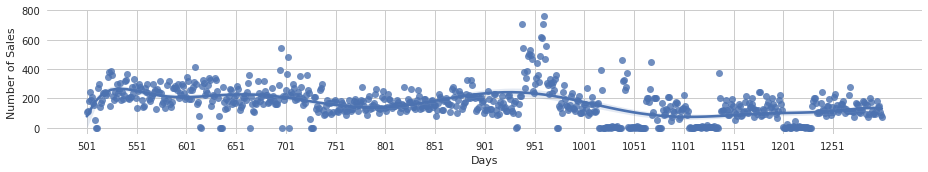

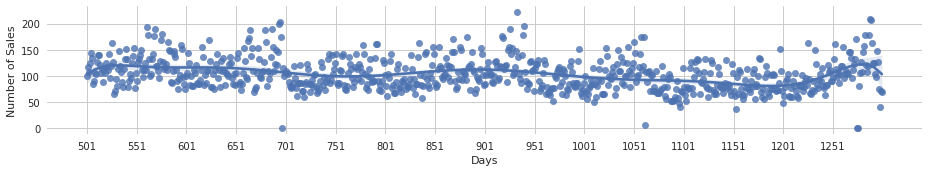

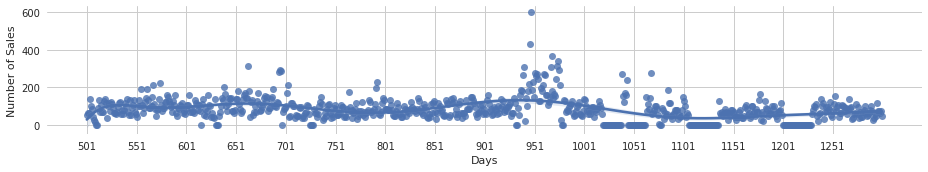

In [ ]:
# vẽ biểu đồ thể hiện mật độ và xu hướng phát triển của sản phẩm có ID = FOODS_3_090_CA_3_validation, miền giá trị từ d_500 đến d_1300, bước phân nhóm dữ liệu được lấy mặc định theo đầu hàm = 50
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
# vẽ biểu đồ với sản phẩm ID = FOODS_3_586_TX_2_validation
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
# vẽ biểu đồ với sản phẩm ID = FOODS_3_090_CA_1_validation
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)

Looking at the above graphs, our regression model does a fairly good job of fitting the line on the sales trend observed between the days 500th to 900th, for the item ids 'FOODS_3_090_CA_3_validation' and 'FOODS_3_586_TX_2_validation'. The graph also points out to the similar trends of troughs and crests between the specific days pointing out towards the occurence of special occasions and events that are driving sales. (To do _explain on order of polynomial and take more cases of ids across foods, household categories across different stores)

**Questions on Sales Revenue?**

First of all, we'd be interested in finding out what the specific revenue with respect to each product is? But since we have not been provided the dataset with ids (product_ids) in sell_prices_df(revenue dataframe) and there is a mismatch in dataset entries between the both datasets (train_sales_df with almost 30000 rows and sell_prices_df with almost 6M entries), therefore, atbest, a rough estimate could be made by merging both datasets.

Frotunately enouhg, Revenue Dataframe (sell_prices_df) has the categorical level data available, so we could make an estimation regarding the items sold in each category to see what is the specific price where most items are getting sold.

We'll first try fitting the non-parametric method of probability distribution since we suspect the data distribution might not be exact replica of a distribution we have seen before, and may include peaks or outliers.

If the behavior of data distribution does not resemble a known distribution, further investigation would be made to remove the specific data outliers




In [ ]:
# truy xuất 3 phần tử đầu tiên của tập dữ liệu sell_prices_df
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [ ]:
# tạo thêm 1 cột dữ liệu category cho tập dữ liệu sell_prices_df
# giá trị được trích xuất trực tiếp từ cột item_id qua concept lấy thành phần đầu tiên trong chuỗi kí tự item_id
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

In [ ]:
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price,category
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES


**Distribution of Price Among Categories?**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



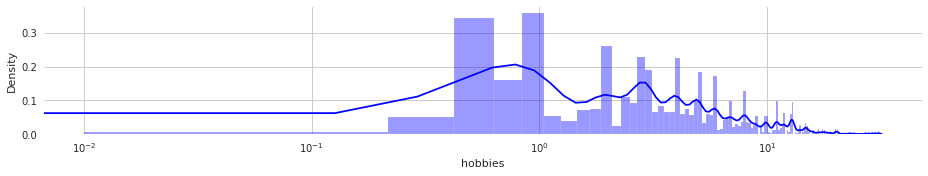

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



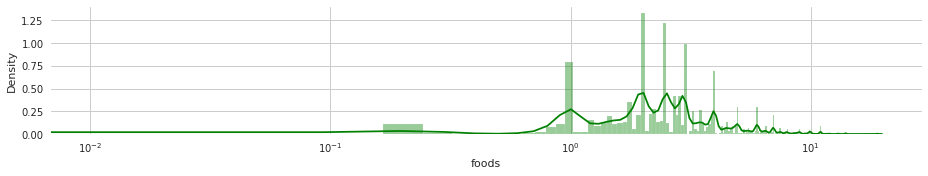

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



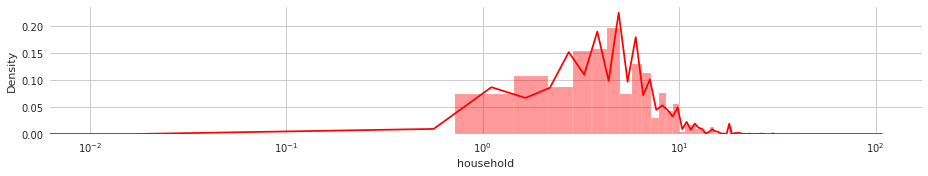

In [ ]:
sns.set_style('whitegrid') # thiết lập thuộc tính mặc định cho toàn bộ kiểu dáng (style) cho toàn bộ các biểu đồ sẽ được vẽ
#plt.figure(figsize=(15,5))

# định nghĩa hàm vẽ biểu đồ xác xuất phân phối các mặt hàng theo giá bán sell_prices
# df: tập dữ liệu 
# category: tên danh mục sản phẩm cần thể hiện
# bin_size : gía trị xác định phạm vi giống nhau của các giá trị dữ liệu 
# color : màu sắc hiển thị
# label : tiêu đề chú thích 
def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    # khởi tạo biên đối tương Figure & Axes
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )

    # thiết lập các thuộc tính của biểu đồ, bao gồm
    # tập dữ liệu cần phân tích được trích xuất là sell_price của các dòng dữ liệu có category = gía trị category đầu vào
    # chú thích trục X 
    # phạm vi của các dữ liệu có sell_price = nhau
    # màu sắc - color 
    # đối tượng thể hiện hình dáng biểu đồ ax
    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log') # thiết lập giá trị co giãn (scale) hiển thị trên trục X, giá trị được tham chiếu từ matplotlib.scale.LogScale
    plt.legend()
    plt.show() # vẽ biểu đồ


# biểu đồ xác xuất phân phối các mặt hàng có category = HOBBIES
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   

# biểu đồ xác xuất phân phối các mặt hàng có category = FOODS
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 

# biểu đồ xác xuất phân phối các mặt hàng có category = HOUSEHOLD
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

We could extract following useful information by looking at these kde plots.

* The probability distribution plot of the **household** items follows an almost normal distribution with a mean centered around a price of 5 Dollars and most items being sold within the 1 to 10 dollars range. This would indicate that most household items that are getting sold lie within the price bracket of 25 cents to 10 dollars
* **Foods** items prices is a multimodal distribution indicating frequent variation in interest among food items purchased. The values occur both towards the relative higher price bracket as well as lower price bracket indicating that the degree of interest of consumers in food items is not only varied but that the Walmart stores have a catalogue of food items that are peaking consumer's interest across different categories. The price bracket in this case also happens to lie within 2 cents to 10 dollars with only very few items getting sold past that range
* The probability distribution of **hobbies** related items prices indicates a mix of bimodal and multimodal distributions. This indicates that while a few items in specific category were sold more than others (first peak that lies in the area between 0.01 dollar to 1 dollar) there are also items towards a relative higher price bracket that have been also sold quite frequently enought to give it a multimodal distribution with small decreasing peaks indicative of decreasing interest in hobbies related items that are relatively expensive but sill significant enough to generate consumer interest.


**Removing Outliers to Observe Price Distribution?**

**Quartile Method**

In [ ]:
# định nghĩa hàm khử các yếu tố được định nghĩa là ngoại vi có thể ảnh hưởng đến kết quả phân tích dữ liệu
# mục đích của hàm này là làm sạch dữ liệu, đưa miền giá trị về phân vùng mong muốn để có kết quả phân tích gần chính xác nhất 
def remove_outliers(df):
    
    '''
    removes the outliers in continous features using quartile ranges
    
    inputs: df(df specified with continous features along side categorical features)
    returns: df with removed outliers
    '''
    # trích xuất miền dữ liệu phân vị đầu tiên của tập dữ liệu đầu vào (sẽ là sell_prices)
    # kết quả sẽ là giá trị trung vị miền dưới của tập dữ liệu sell_prices, có thể hiểu là cận dưới của tập hợp giá thấp 
    Q1=df.quantile(0.25) 

    # giá trị trung vị của miền trên tập dữ liệu sell_price, có thể hiểu là cận trên của tập giá cao
    Q3=df.quantile(0.75) 


    # định nghĩa miền kì vọng    
    IQR=Q3-Q1

    # trích xuất dữ liệu bao gồm các dòng dữ liệu có giá nằm trong miền kì vọng, điều kiện bao gồm
    # < cận dưới - 1.5 x miền kì vọng
    # > cận trên + 1.5 x miền kì vọng 
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final

# khởi tạo biến df, là dữ liệu được trích xuất từ tập dữ liệu sell_prices, chỉ lấy 2 cột là category, sell_price
df = sell_prices_df[['category', 'sell_price']]
# khử các giá trị nằm ngoài miền kì vọng 
df = remove_outliers(df)

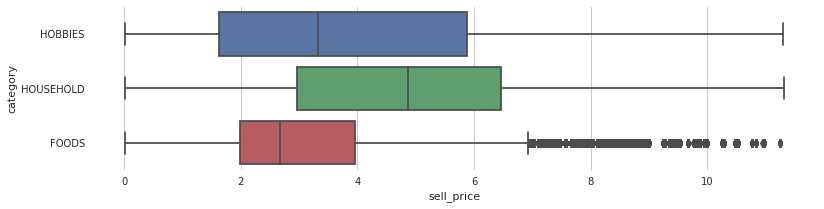

In [ ]:
sns.set_style('whitegrid') # thiết lập thuộc tính hiển thị của vùng trực quan hoá dữ liệu 
sns.axes_style(style='ticks') # thiết lập thuộc tính hiển thị của lưu đồ
plt.figure(figsize=(13,3)) # khởi tạo đối tượng Figure quy định kích thước vùng trực quan dữ liệu 
sns.boxplot(y=df['category'], x=df['sell_price']) # xác định kiểu dữ liệu, phân bổ gía trị trục X, Y
plt.show() # vẽ biểu đồ

After removing most of the outliers, it is apparent that for

* FOODS related items, 75 % of the items sold are those that are less than 4 dollars
* HOBBIES related items, 75 % of the items sold were less than 6 dollars with an mean price centered around 3.25-3.5 dollars
* HOUSEHOLD items, 75 % of the items sold were less than 6.5 dollars.

It also represents that there are quite a few outliers in our price data. Since we had observed before using the kdeplots, that the distributions of the dataset were mostly skewed, we used the quartile method of removing the outliers.



**Distribution of Sales On Weekdays & Special Occasions?**

Our third dataset named, calendar_df, provides valuable information along the timeseries for the dataset of product_id. This dataset also contains information about Special occasions, SNAP (Supplementary Nutrition Assistance Programme) in the USA and coupled with the product_id dataset i.e. train_sales_df would be helpful in observing sales along weekdays, specific dates and special occasions

In [ ]:
calendar_df.head(3) # truy xuất 3 phần tử đầu tiên của tập dữ liệu calendar_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# thống kê dữ liệu theo phân nhóm event_name_1 - event_type_1, tổng hợp dữ liệu cột wday bằng ĐẾM tổng số dòng trong phân nhóm này.
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

Looking at the distribution of data in 'event_name_1' and 'event_type_1' it is clear the data here relates to holidays which could reveal important trends when coupled with the information of sales made on the specific event.



In [ ]:
# thống kê dữ liệu theo phân nhóm event_name_2 - event_type_2, tổng hợp dữ liệu cột wday bằng ĐẾM tổng số dòng trong phân nhóm này.

calendar_df.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

In [ ]:
calendar_df.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


It seems a few entries that have not been made to the 'event_name_1' attribute have been made available in a different category



In [ ]:
#Making in and including a new entry of days as well as merging the events_1 and event_2 into
# a single new events_names and types category

# bổ sung thêm 1 cột vào tập dữ liệu calendar_df, tên là days, 
# giá trị được phân tích từ phần tử thứ 2 sau khi phân tách giá trị calendar_df['date']
calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]

# bổ sung thêm 1 cột vào tập dữ liệu calendar_df, tên là events_names
# giá trị được tổng hợp bằng cách nối 2 giá trị cột event_name1 & event_name_2
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)

# bổ sung thêm 1 cột vào tập dữ liệu calendar_df, tên là events_type
# giá trị được tổng hợp bằng cách nối 2 giá trị cột event_type_1 & event_type_2
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

**What are SNAP_CA, SNAP_TX, SNAP_WI?**

SNAP stands for "Supplementary Nutrition Assistance Program" that is a federal level program aimed at providing food essentials to low-income households. This program is geared towards providing the food essentials and within the current dataset, the catagories of household items and hobbies items do not fall within the requirements of this program.

This program is only geared towards fighting the food hunger in america and only food related items can be purchased under this program



In [ ]:
calendar_df.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,days,events_names,events_types
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29,NaN,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30,NaN,NaN
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31,NaN,NaN


In [ ]:
# thống kê dữ liệu, phân nhóm theo event_type, giá trị dữ liệu thống kê được tính bằng ĐẾM tổng số snap_CA có giá trị hợp lệ
# cột dữ liệu mới được đặt tên là counts
df = calendar_df.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

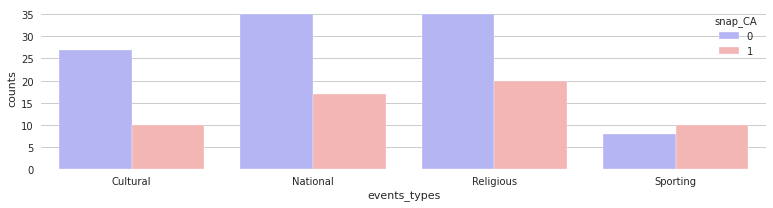

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))

# thiết lập giá trị hiển thị biểu đồ, bao gồm 
# data: tập giá trị cần khảo sát
# trục X : tập giá trị từ cột event_types của data 
# trục Y : tập giá trị từ cột counts của data
# hue : đơn vị dữ liệu cần khảo sát (ở đây là snap_CA) đã được thống kê và tổng hợp bên trên
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show() # vẽ biểu đồ

In [ ]:
# thống kê dữ liệu, theo phân nhóm event_names, giá trị dữ liệu thống kê được tính bằng ĐẾM tổng số snap_CA có giá trị hợp lệ
# cột dữ liệu mới được đặt tên là counts
df = calendar_df.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')

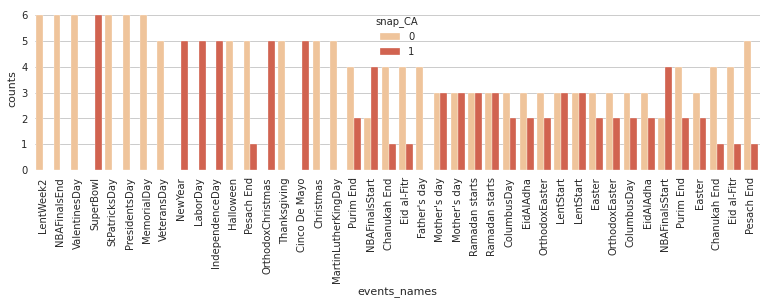

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))

# thiết lập giá trị hiển thị biểu đồ, bao gồm 
# data: tập giá trị cần khảo sát
# trục X : tập giá trị từ cột event_types của data 
# trục Y : tập giá trị từ cột counts của data
# hue : đơn vị dữ liệu cần khảo sát (ở đây là snap_CA) đã được thống kê và tổng hợp bên trên
# order : sắp xếp thứ tự hiển thị giảm dần theo tổng số events_names 
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90) # quy định chú thích hiển thị 1 góc xuông 90 độ để đảm bảo dữ liệu thể hiện tốt nhất
plt.show() # vẽ biểu đồ

A look at both of these plots indicates the special occasions when the SNAP programme in CA were availed.



**Distribution of Sales Items vs Sales Revenue?**

Now that we have product_id df as well as revenue_df, we'll merge the dataset now to start exploring trends of item_specific_data and sale_price_specific data



In [ ]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
# tồng hợp dữ liệu, tạo ra thực thể kết hợp của 2 tập dữ liệu train_sales_df - sell_prices_df 
# theo phương pháp Inner JOIN, dựa trên cột item_id làm điều kiện liên kết 
# left_index = True, right_index = True : sử dụng cả 2 index trên 2 tập dữ liệu trong quá trình liên kết 
# validate = 1:1 loại liên kết one_to_one, kiểm tra và kết hợp 2 đơn vị dữ liệu có cùng 1 khoá dữ liệu trên 2 tập dữ liệu thành 1 dòng duy nhất 
train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner', on='item_id', 
                                            left_index=True, right_index=True, 
                                            validate="1:1")

In [ ]:
# thống kê dữ liệu, phân nhóm theo cat_id - state_id - store_id_x, cột dữ liệu tổng hợp được TÍNH bằng tổng cộng gía trị từ sell_price
# cột dữ liệu tổng hợp mới được đặt tên là total_revenue 
df = train_sales_prices_df.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')

# sắp xếp dữ liệu tăng dần theo total_revenue 
df = df.sort_values(by='total_revenue', ascending=False)

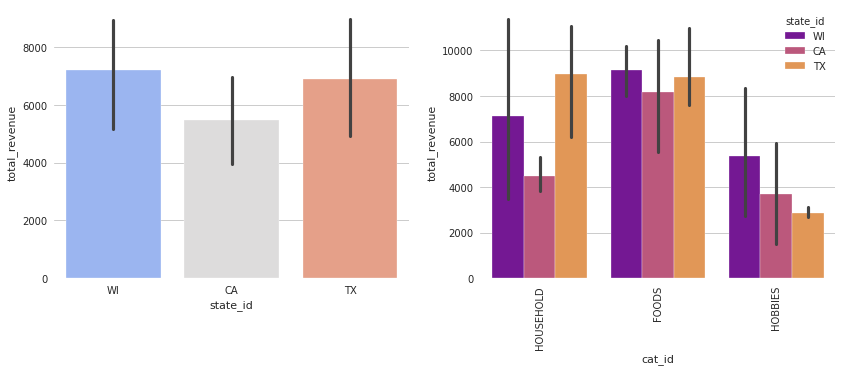

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

# thiết lập thông số cho biểu đồ hiển thị, bao gồm
# trục X : thể hiện dữ liệu từ cột state_id
# trục Y : thể hiện dữ liệu từ cột total_revenue
# data cần được khảo sát được phân bổ từ biến df (đã thực hiện tổng hợp dữ liệu bên trên)
# kiểu dáng thể hiện biểu đồ
sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)

# thiết lập thông số cho biểu đồ hiển thị (tương tự bên trên)
# trong đó, trục X được thể hiện dữ liệu từ cột cat_id
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

plt.xticks(rotation=90) # thiết lập góc thể hiện chú thích, nếu chú thích dài sẽ hiển thị theo chiều dọc để đảm bảo góc nhìn tốt nhất 
plt.show() # vẽ biểu đồ, biểu đồ này cho ta thấy sự phân phối của Doanh Thu bán hàng được phân chia chi tiết theo tiểu Bang - State (hình 1) & Danh mục sản phẩm - Category (hình 2)

Despite the fact that salesprices data contains almost 6M entries, in the present case, we are only considering common entries between revenue df and product_ids df. A few significant insights have come forward, i.e.

* Although we saw that california consistently was the one state where the unique product_id most sales were made, the most revenue collected came from the Wisconsin State stores
* Similarly, within the distribution of Categories, WI and TX contrinute more sales revenue than do the CA stores.
* Wisconsin leads the revenue in FOODS and HOBBIES, while Texas leads the revenue in HOUSEHOLD
* CA tends to contribute the smallest revenue out of all three states, despite having the most sales of items in its stores locations


In [ ]:
#train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d'), 
 #                                                                   left_index=True, right_index=True,
 #

In [ ]:
##train_sales_cal_df.T


**Behaviour on TimeSeries & Analysis?**

Timeseries questions would involve merging the datasets of product_ids and data information to enable a thorough analysis through time. We could find out information on the sales of items alongside the timeseries and also find out what specific effects, the weekends and specials occasions might have had on number of units sold

**Rolling Averages** : Rolling averages are a useful tool to employ to understand the long term effects in a timeseries represented data. The rationale behind using rolling averages is the fact that resulting reading coming out of rolling averages smoothes out the data against daily fluctuations, and could help data professionals understand the long term impact of the sales/inventory across time. Therefore, we are going to use both rolling average as a necassary tool to help aid ou



**Distribution of Total Sales Against Product_id on TimeSeries?**

In [ ]:
#Changing the date type to datetime so that it is depicted as so:

#calendar_df.date = pd.to_datetime(calendar_df.date)
#type(calendar_df.date)

In [ ]:
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales_all_days,avg_sales_all_days,median_sales_all_days
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,3,0,1,1,600,0.313643,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,493,0.257710,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,1,1,288,0.150549,0.0


In [ ]:
# tổng hợp dữ liệu, lần lượt thực hiện các bước sau 
# tập dữ liệu train_sales_df được đánh index trên các cột có tiền tố d_x (danh sách các tên cột được quy định trong biến d_cols đã khai báo đầu chương trình)
# train_sales_df được chuyển đổi định dạng theo đường chéo, để biến đổi cột > dòng, dòng > cột (mục đích của việc này là đảm bảo cùng chiều với tập dữ liệu calendar_df)
# thực hiện kết hợp 2 thực thể train_sales_df - calendar_df theo phương thức INNER (mặc đinh) trên khoá kết hợp là date
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

# thống kê dữ liêu, tạo ra thêm 1 cột dữ liệu tổng hợp tên là total_sales, được TÍNH bằng tổng cộng các giá trị theo chiều ngang - trục X
# ý nghĩa: tổng doanh thu theo đơn vị ngày, của toàn bộ ID sản phẩm
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

In [ ]:
# trích xuất dữ liệu, đưa về tập hơn dữ liệu bao gồm date - total_sales, ngày và tổng doanh số theo ngày.
train_sales_cal_df = train_sales_cal_df[['total_sales']]
# thực hiện đánh lại index trên tập dữ liệu mới, tối ưu hoá tốc độ xử lý 
train_sales_cal_df = train_sales_cal_df.reset_index()

In [ ]:
train_sales_cal_df.head(3)

,date,total_sales
0,2011-01-29,32631
1,2011-01-30,31749
2,2011-01-31,23783


In [ ]:
# khởi tạo và thiết lập đối tương Figure, chuẩn bị thể hiện biểu đồ, bao gồm
# train_sales_cal_df : tập dữ liệu sử dụng khảo sát dữ liệu (đã được tổng hợp bên trên)
# x : phân bổ giá trị trục X = tập dữ liệu cột date 
# y : phân bổ giá trị trục Y = tập dữ liệu cột total_sales
# template :  ánh xạ từ plotly.graph_objects.layout.Template, là mẫu thể hiện hình dạng biểu đồ
# title, width, height : tiêu đề, chiều dài, chiều rộng biểu đồ
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

# quy định hiển thị công cụ điều chỉnh miền giá trị trục X (date) đang được thể hiện
fig.update_xaxes(rangeslider_visible=True)

# quy định thể hiện công cụ lọc dữ liệu (filter) bao gồm các giá trị khoảng thời gian phổ biến, bao gồm
# 1m : khoảng thời gian trong 1 tháng
# 6m: khoảng thời gian trong 6 tháng 
# YTD : year to date, từ ngày này năm ngoái > ngày hiện tại
# 1y : khoảng thời gian trong 1 năm
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

# vẽ biểu đồ, biểu đồ này cho ta theo dõi tình hình phát triển của Doanh số bán hàng (total_sales)
fig.show()

From this graph it is difficult to tell the trend and seasonality patterns within our dataset. Althogh there is an increasing trend, the number of values for the entire dataset represented in the graph make it difficult to ascertain the true picture.


Fortunately, using the seasonal_decompose module in statsmodel, we could find out the seasonality and trend patterns in the timeseries. We are going to choose the "mulitplicative seasonality" owing to the fact of variability in the magnitude of the number of sales along the timeseries



In [ ]:
# khai báo sử dụng gàn seasonal_decompose, phục vụ cho các xử lý dữ liệu theo chuỗi thời gian
from statsmodels.tsa.seasonal import seasonal_decompose

# định nghĩa hàm phân tích dữ liệu theo chuỗi thời gian, tham số bao gồm
# df : tập dữ liệu cần được xử lý 
# model_specified: mô hình xử lý, bao gồm các gía trị (multiplicative, additive)
# period : số ngày cần phân tích 
def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    # khởi tạo đối tượng DecomposeResult, bao gồm các giá trị biến số
    # x : tập dữ liệu xử lý, được đánh dấu index trên cột có tên date 
    # model: mô hình xử lý (phân bổ từ biến đầu vào)
    # period: số ngày tiến hành xử lý (phân bổ từ biến đầu vào)
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    # ước tính xu hướng tổng quan của dữ liệu theo thời gian
    est_trend = df_decomposition.trend

    # chuẩn hoá dữ liệu, thiết lập chỉ mục (index) về cột date
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    
    # xu hướng theo mùa vị, mẫu phát triển theo quý, tháng  
    est_seasonal = df_decomposition.seasonal
    
    # chuẩn hoá dữ liệu, thiết lập chỉ mục (index) về cột date
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    
    # thành phần nhiễu còn lại sau khi trích xuất hết các thành phần ở trên
    est_residual = df_decomposition.resid
    
    # chuẩn hoá dữ liệu, thiết lập chỉ mục (index) về cột date
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

# trích xuất tập dữ liệu train_sales_df (dòng 400 - 700), phân bổ vào biến sample_time_s1
sample_time_s1 = train_sales_cal_df[400:700]

# gọi hàm phân tích xu hướng phát triển dữ liệu theo chuỗi thời gian (định nghĩa bên trên)
# gán tập dữ liệu ước tính xu hướng tổng quan dũ liệu vào biến est_trend\
# gán tập dữ liệu xu hướng theo mùa vị, mẫu phát triển theo quý/ tháng vào biến est_seasonal
# gán tập dữ liệu nhiễu vào biến est_residual
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

In [ ]:
sample_time_s1.head(3)

,date,total_sales
400,2012-03-04,40325
401,2012-03-05,32703
402,2012-03-06,31532


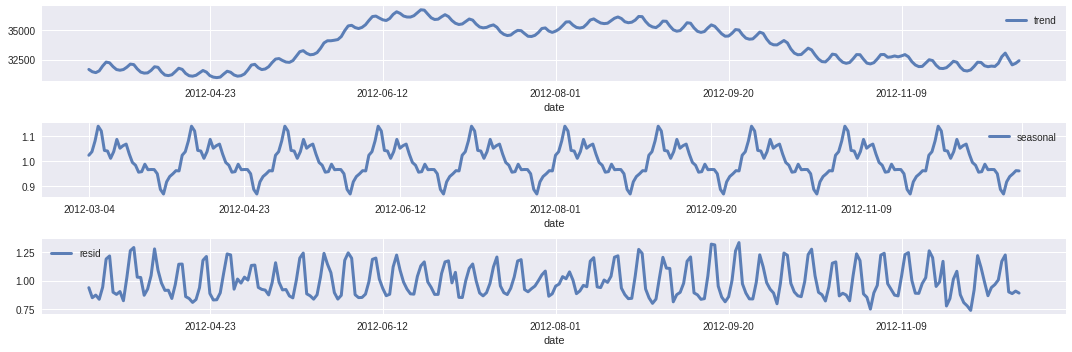

In [ ]:
# Khởi tạo đối tượng Figure và các đối tượng Axes để chuẩn bị trực quan dữ liệu 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

# phân bổ dữ liệu thể hiện xu hướng phát triển tổng quan dữ liệu
est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)

# phân bổ dữ liệu thể hiện xu hướng theo mùa vị 
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)

# phân bổ dữ liệu thể hiện độ thặng dư của tập dữ liệu theo chuỗi thời gian  
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

# vẽ biểu đồ thể hiện xu thế phát triển của dữ liệu (total_sales) theo 3 đơn vị: tổng quan, theo mùa vị, độ nhiễu/ ảnh hưởng
fig.tight_layout()
plt.show()

fter looking at the trend, the seasonality and residuals patterns, we have the following information gathered:

* There is definitely seasonality in our dataset, and in order to observe its pattern, we have taken a subset of dataset
* Since the seasonal and residual components are changing the trend line by an amount that is 'Dependent" of the changes in seasonal and residual components, we have a multiplicative behaviour


In [ ]:
train_sales_cal_df.head(3)

,date,total_sales
0,2011-01-29,32631
1,2011-01-30,31749
2,2011-01-31,23783


In [ ]:
# chuẩn hoá dữ liệu, đặt lại chỉ mục trên tập dữ liệu train_sales_cal_df trên cột date 
# chúng ta sẽ thấy cột dữ liệu date thường xuyên được truy cập trong những đoạn chương trình bên dưới, mục đích phục vụ cho các phân tích theo chuỗi thời gian. (time serials)
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [ ]:
train_sales_cal_df.head(3)

,total_sales
date,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783


In [ ]:
# định nghĩa hàm vẽ biểu đồ thể hiện tình hình phát triển của doanh số theo từng dòng thời gian, bao gồm các biến đầu vào
# df : tập dữ liệu cần được khảo sát (lưy ý, tập dữ liệu này cần được chuẩn hoá theo tiêu chuẩn chuỗi thời gian - giá trị dữ liệu), tham khảo từ biến train_sales_cal_df
# title_text: tiêu đề 
# rolling_day: giá trị dòng thời gian cần khảo sát 
# height: kích thước
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    #  thiết lập kiểu hiện thi của biểu đồ
    sns.set_style('whitegrid')

    # khởi tạo đối tượng Figure và Axes để thực hiện trực quan hoá dữ liệu 
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))

    # phân bổ giá trị biểu đồ, bao gồm
    # cấu hình đối tượng Figure, các giá trị quy định hiển thị bao gồm màu sắc, tiêu đề
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    
    # phân bổ giá trị tập dữ liệu cần khảo sát vào tập dữ liệu của biểu đồ
    # với giá trị biến rolling_day, giá trị N được tính bằng trung bình cộng các phần từ tư N đến N-rolling_days
    # với định nghĩa trên, các phần từ có vị trí nhỏ hơn rolling_day sẽ có giá trị rỗng (hoạc NaN)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    
    # thực hiện vẽ biểu đồ
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

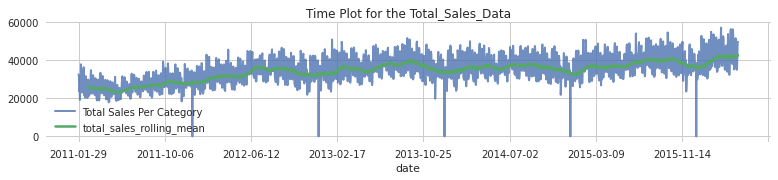

In [ ]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

Looking at the graph, it is obvious that the unit sales across timeline have been on a steady increase. This would imply that

* There are items remaining in inventory must be tracked
* We could plot a sales of a few items to see how the behavior of each one fares across timeline.


In [ ]:
#finding the product_ids of 25 most sold units
# thống kê dữ liệu, thực hiện phân nhóm dữ liệu theo ID sản phẩm (cột id)
# tổng hợp dữ liệu cột mới bằng tổng cộng giá trị cột total_sales_all_days
# sắp xếp dữ liệu theo chiều giảm dần
# lấy ra 25 phần tử từ vị trí đầu tiên > mục tiêu thống kê được 25 đơn vị dữ liệu có Tổng Doanh số lớn nhất 
# gán tập dữ liệu này vào biến train_sales_most_sold_25
#train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum(axis=1).sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)[:25]

# thực hiện đặt lại chỉ mục, đặt tên cột dữ liệu mới tổng hợp là total_sales
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')

# phân tách để lấy ra 5 phần tử từ vị trí đầu tiên của tập dữ liệu, thực hiện lập chỉ mục dựa trên các giá trị là số nguyên 
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,FOODS_3_090_CA_3_validation,250502
1,FOODS_3_586_TX_2_validation,192835
2,FOODS_3_586_TX_3_validation,150122
3,FOODS_3_586_CA_3_validation,134386
4,FOODS_3_090_CA_1_validation,127203


In [ ]:
# tạo mới cột dữ liệu state, với giá trị được phân tách từ chuỗi ID định danh sản phẩm
# phân tách theo dấu _, lấy vị trí có chỉ mục = 3
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]

# thống kê dữ liệu, thực hiện phân nhóm theo cột state, tính toán giá trị tổng hợp bằng tổng cộng total_sales 
# sắp xếp tập dữ liệu theo giá trị giảm dần của giá trị vừa tổng hợp 
# mục đích tìm ra được tiểu bang - State có Doanh số bán hàng tốt nhất
#train_sales_most_sold_25.groupby(['state'])['total_sales'].sum(axis=1).sort_values(ascending=False)
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum().sort_values(ascending=False)

state
TX    1233196
CA    1005717
WI     470367
Name: total_sales, dtype: int64

So, out of the most popular categories of 25 most sold items, more items had been sold in Texas than in either California or Wisconsin



In [ ]:
# chuyển đồi định dạng theo đường chéo, để biến đổi cột > dòng, dòng > cột (mục đích của việc này là đảm bảo cùng chiều với tập dữ liệu calendar_df)
# tổng hợp dữ liệu, sau khi đảm bảo 2 tập dữ liệu đã cùng phương vị, tiến hành kết hợp dữ liệu với calendar_df dựa trên cột date 
# dánh chỉ mục tập dữ liệu tổng hơp trên cột date, mục đích của việc này là để tối ưu hoá tốc độ xử lý và chuẩn hoá dữ liệu cho các bước phân tích, trực quan hoá dư liệu theo chuỗi thời gian (Time series) bên dưới
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

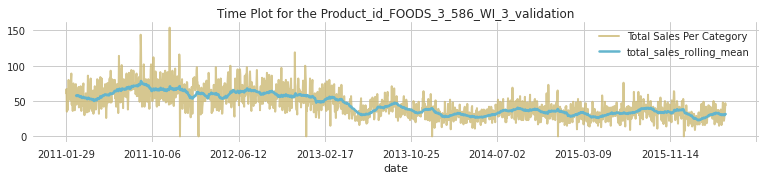

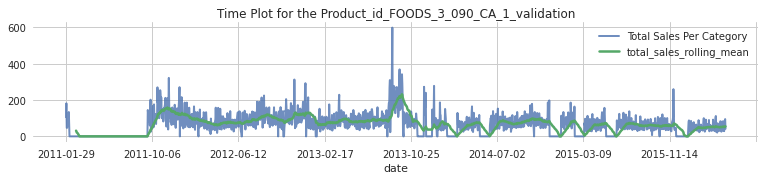

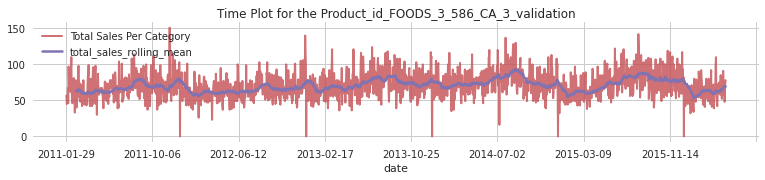

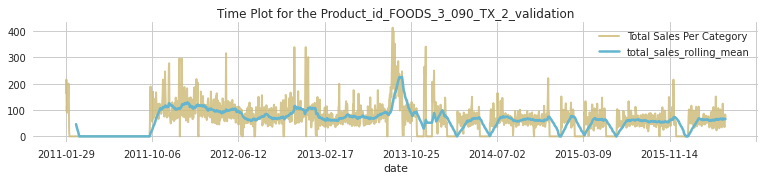

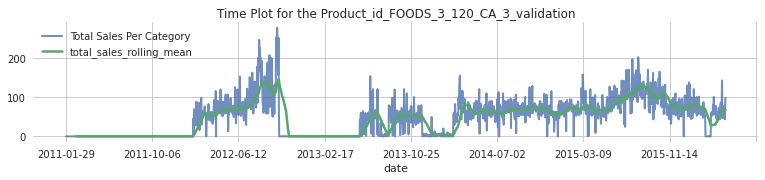

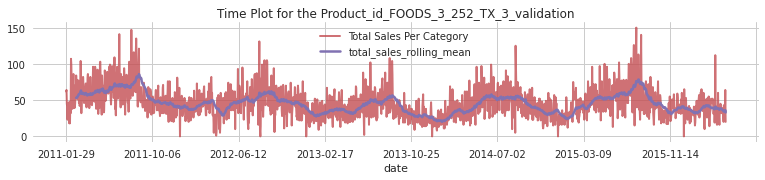

In [ ]:
# thực hiện vẽ biểu đồ thể hiện tình hình doanh số theo chuỗi thời gian, các ID sản phẩm lần lươt được gọi từ biến đầu vào
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")

**Distribution of Total Sales Against Each Category?**

In [ ]:
#train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum(axis=1).\

# tổng hợp dữ liệu
# đầu tiên, thực hiện thống kê tập dữ liệu train_sales_df theo phân nhóm cat_id, tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tiền tố d_x (được phân bổ trong nội dung biến d_cols)
### mục đích là thống kê Doanh số bán hàng theo từng Danh mục sản phẩm
# sau đó, thực hiện chuyển đổi định dạng của tập dữ liệu train_sales_df theo đường chéo, để biến đổi cột > dòng, dòng > cột (mục đích của việc này là đảm bảo cùng chiều với tập dữ liệu calendar_df)
# tổng hợp dữ liệu, sau khi đảm bảo 2 tập dữ liệu đã cùng phương vị, tiến hành kết hợp dữ liệu với calendar_df dựa trên cột date 
# cuối cùng, thực hiện đánh chỉ mục trên cột date của tập dữ liệu đã tổng hợp
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634


In [ ]:
# định nghĩa đầu hàm để vẽ biểu đồ dạng bong bóng, thể hiện xu hướng phát triển của dữ liệu theo dòng thời gian, bao gồm
# df: tập dữ liệu đầu vào thực hiện khảo sát
# text: tiêu đề biểu đồ
# sample_onward : vị trí bắt đầu của tập dữ liệu khảo sát 
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''

    # khởi tạo đối tượng Figure, quy định các thuộc tính thực hiện trực quan hoá dữ liệu
    fig = go.Figure()

    # thiết lập giá trị dòng thời gian, và dữ liệu hiển thị trên biểu đồ
    # đầu tiên, gía trị c được phân bổ từ các tên cột có vị trí từ đầu đến vị trí 4 của tập dữ liệu đầu vào
    # trục X được phân bổ giá trị của chỉ mục tập dữ liệu đầu vào (ở đây là cột date), từ vị trí đầu quy định với biến samples_onwards
    # trục Y được lần lượt phân bổ giá trị của các cột còn lại tập dữ liệu, tên cột phân bổ từ biến c 
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    # thiết lập cấu hình thể hiện dữ liệu trên biểu đồ
    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    # thiết lập cấu hình và dữ liệu bộ lọc, bao gồm các khoảng thời gian
    # 6m : trong vòng 6 tháng 
    # 6m : trong vòng 6 tháng 
    # YTD : year to date, ngày này năm ngoái > hiện tại 
    # 1y: trong vòng 1 năm 
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

# vẽ biểu đồ thể hiện Doanh số bán hàng chi tiết theo Danh mục sản phẩm theo dòng thời gian 
plotly_time_plot_markers(train_sales_cal_df, 'Category')  

The results of the plot indicate that:

* There is defintely an increase in the number of items being sold with time
* The items sold in the Food and Household category have seen a more gradual increase than those of hobbies related items.


**Distribution of Total Sales Sold Per State**

In [ ]:
#train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum(axis=1).T.merge(calendar_df.set_index('d')['date'], 

# tổng hợp dữ liệu
# đầu tiên, thực hiện thống kê tập dữ liệu train_sales_df theo phân nhóm state_id, tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tiền tố d_x (được phân bổ trong nội dung biến d_cols)
### mục đích là thống kê Doanh số bán hàng theo từng khu vực bán hàng, tiểu Bang - State
# sau đó, thực hiện chuyển đổi định dạng của tập dữ liệu train_sales_df theo đường chéo, để biến đổi cột > dòng, dòng > cột (mục đích của việc này là đảm bảo cùng chiều với tập dữ liệu calendar_df)
# tổng hợp dữ liệu, sau khi đảm bảo 2 tập dữ liệu đã cùng phương vị, tiến hành kết hợp dữ liệu với calendar_df dựa trên cột date 
# cuối cùng, thực hiện đánh chỉ mục trên cột date của tập dữ liệu đã tổng hợp
train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum().T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
#train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

,CA,TX,WI
date,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309
...,...,...,...
2016-04-20,15148,9600,10595
2016-04-21,14488,9602,10943
2016-04-22,17095,10615,12807


In [ ]:
from plotly.subplots import make_subplots

# định nghía hàm vẽ biểu đồ thể hiện Daonh số bán hàng theo chuỗi thời gian, bao gồm
# df: tập dữ liệu cần được khảo sát (lưy ý, tập dữ liệu này cần được chuẩn hoá theo tiêu chuẩn chuỗi thời gian - giá trị dữ liệu), tham khảo từ biến train_sales_cal_df
# text: tiêu đề biểu đồ
# start_col, end_cold: vị trí đầu cuối quy định loại dữ liệu cần được khảo sát (sẽ được phân tách từ danh sách các cột của tập dữ liệu đầu vào df) 
# rolling_day: khoảng rộng dòng thời gian cần khảo sát 
def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    # khởi tạo đối tượng Figure, quy định các thuộc tính thực hiện trực quan hoá dữ liệu
    fig = go.Figure()

    # thiết lập giá trị dòng thời gian, và dữ liệu hiển thị trên biểu đồ
    # đầu tiên, gía trị c được phân bổ từ các tên cột có vị trí được quy định bởi biến start_col, end_col
    # trục X được phân bổ giá trị của chỉ mục tập dữ liệu đầu vào (ở đây là cột date)
    # trục Y được lần lượt phân bổ giá trị TRUNG BÌNH của tập dữ liệu tiến hoá trong khoảng rolling_days 
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    # thiết lập thông tin hiển thị biểu đồ
    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    # thiết lập cấu hình và dữ liệu bộ lọc, bao gồm các khoảng thời gian
    # 6m : trong vòng 6 tháng 
    # 6m : trong vòng 6 tháng 
    # YTD : year to date, ngày này năm ngoái > hiện tại 
    # 1y: trong vòng 1 năm 
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

# vẽ biểu đồ thể hiện Daonh số bán hàng theo dòng thời gian, chi tiết theo từng khu vực bán hàng 
plotly_time_plot_rolling(train_sales_cal_df, 'State')

While there has been an increase in the number of sales across all three states i.e. CA, TX, and WI interesting to note is the fact that:

* There is an overall increase in the sales of items across all states
* WI sales cross TX sales at around Oct'14 and Sept'15 indicating that that could be boost in the sales of category of items that are seasonal. We'll try and investigate the sales of categories across separate states to further shed a light on this answer


In [ ]:
#referring to the solution provided at https://stackoverflow.com/questions/43223615/join-dataframes-one-with-multiindex-columns-and-the-other-without

#train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum(axis=1).T\

# tổng hợp dữ liệu
# đầu tiên, thực hiện thống kê tập dữ liệu train_sales_df theo phân nhóm CẶP state_id - cate_id
# tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tiền tố d_x (được phân bổ trong nội dung biến d_cols)
### mục đích là thống kê Doanh số bán hàng theo từng khu vực bán hàng, tiểu Bang - State & Danh mục sản phẩm
# sau đó, thực hiện chuyển đổi định dạng của tập dữ liệu train_sales_df theo đường chéo, để biến đổi cột > dòng, dòng > cột (mục đích của việc này là đảm bảo cùng chiều với tập dữ liệu calendar_df)
# cuối cùng, thực hiện tổng hợp dữ liệu dựa vào khoá của 2 tập dữ liệu dựa vào khoá hiện tại (state_id - cat_id) của train_sales_df và d (calendar_df) 
# tập dữ liệu tổng hợp cuối cùng chính là Doanh số bán hàng theo chuỗi thời gian của phân nhóm state_id - cat_id
train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum().T\
              .join(pd.concat([calendar_df.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(CA, FOODS)","(CA, HOBBIES)","(CA, HOUSEHOLD)","(TX, FOODS)","(TX, HOBBIES)","(TX, HOUSEHOLD)","(WI, FOODS)","(WI, HOBBIES)","(WI, HOUSEHOLD)",dates
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691,2011-01-29
d_2,9862,1561,2382,7030,870,1730,5866,926,1522,2011-01-30


In [ ]:
#train_sales_cal_df = train_sales_cal_df.set_index('dates')

In [ ]:
# tìm ra toàn bộ tên cột trong tập dữ liệu train_sales_cal_df có chứa chuỗi CA và gán vào biến  select_cols_ca
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]

# tìm ra toàn bộ tên cột trong tập dữ liệu train_sales_cal_df có chứa chuỗi TW và gán vào biến  select_cols_tx
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]

# tìm ra toàn bộ tên cột trong tập dữ liệu train_sales_cal_df có chứa chuỗi WI và gán vào biến  select_cols_wi
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
#train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
#train_sales_cal_df = 

# trích xuất dữ liệu từ tập dữ liệu train_sales_cal_df, danh sách trích xuất bao gồm các cột được phân bổ từ biến select_cols_ca
# đây là tập dữ liệu Doanh Số Bán Hàng của tiểu bang CA theo chuỗi thời gian, được phân nhóm theo Danh mục sản phẩm
df_CA = train_sales_cal_df.set_index('dates')[select_cols_ca]

# trích xuất dữ liệu từ tập dữ liệu train_sales_cal_df, danh sách trích xuất bao gồm các cột được phân bổ từ biến select_cols_ca
# đây là tập dữ liệu Doanh Số Bán Hàng của tiểu bang TX theo chuỗi thời gian, được phân nhóm theo Danh mục sản phẩm
df_TX = train_sales_cal_df.set_index('dates')[select_cols_tx]

# trích xuất dữ liệu từ tập dữ liệu train_sales_cal_df, danh sách trích xuất bao gồm các cột được phân bổ từ biến select_cols_ca
# đây là tập dữ liệu Doanh Số Bán Hàng của tiểu bang WI theo chuỗi thời gian, được phân nhóm theo Danh mục sản phẩm
df_WI = train_sales_cal_df.set_index('dates')[select_cols_wi]

#df_CA.columns = [col[1] for col in df_CA.columns]
#df_TX.columns = [col[1] for col in df_TX.columns]
#df_WI.columns = [col[1] for col in df_WI.columns]

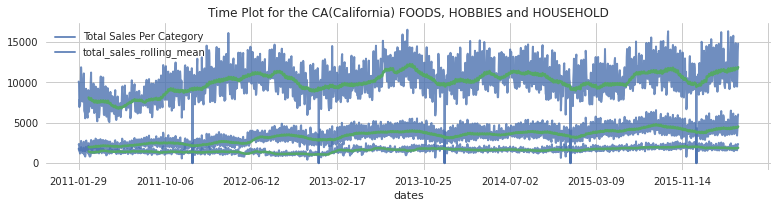

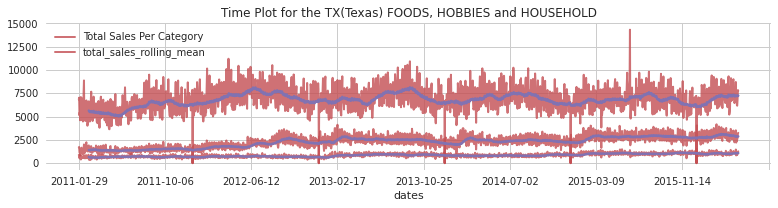

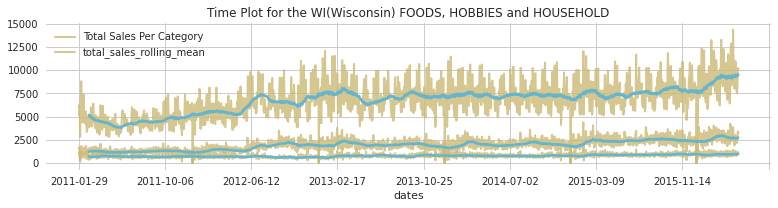

In [ ]:
# vẽ biểu đồ thể hiện Daonh Số bán hàng của tiểu bang CA, phân nhóm theo Danh mục sản phẩm theo chuỗi thời gian
# tập dữ liệu này được phân bổ từ biến df_CA được trích xuất bên trên 
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)

# vẽ biểu đồ thể hiện Daonh Số bán hàng của tiểu bang TX, phân nhóm theo Danh mục sản phẩm theo chuỗi thời gian
# tập dữ liệu này được phân bổ từ biến df_TX được trích xuất bên trên 
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)

# vẽ biểu đồ thể hiện Daonh Số bán hàng của tiểu bang WI, phân nhóm theo Danh mục sản phẩm theo chuỗi thời gian
# tập dữ liệu này được phân bổ từ biến df_WI được trích xuất bên trên 
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

By looking at the above graphs, some of the trends regarding in the food distribution category along separate states have become evident.

* Along the FOODS distribution, both CA and TX see large bumps in sales around june'12 and september'12-October'12 with the next peak coming around in Oct'13 that is larger than the sales in June'12 with the same trend continuing to repeat itself along other dates in 2014, and 2015
* However, the sales along WI stores have a slightly different pattern with peaks of sales occuring in July'12 and next largest being observed in Feb-Mar'13. Similarly, the sales pick up around September in 2013, and then in Mar'13

* In Household items distribution, the peaks of sales across all stores in CA, TX and WI occur around July, March while relatively huge dips in sales occuring in all three locations around the month of Jan-Feb.

* In Hobbies items sales, there is surprising peak in sales (albiet different in actual number of units sold) across similar dates in all store locations (for example Feb'13 and Feb'15) with a slight dip in sale in Aug-Sep'13.


In [ ]:
# tổng hợp dữ liệu
# đầu tiên, thực hiện thống kê tập dữ liệu train_sales_df theo phân nhóm ID định danh sản phẩm
# tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tiền tố d_x (được phân bổ trong nội dung biến d_cols)
# sau đó, thực hiện chuyển đổi định dạng của tập dữ liệu train_sales_df theo đường chéo, để biến đổi cột > dòng, dòng > cột (mục đích của việc này là đảm bảo cùng chiều với tập dữ liệu calendar_df)
# tổng hợp dữ liệu, sau khi đảm bảo 2 tập dữ liệu đã cùng phương vị, tiến hành kết hợp dữ liệu với calendar_df dựa trên cột date 
# cuối cùng, thực hiện đánh chỉ mục trên cột date của tập dữ liệu đã tổng hợp
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
#train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

# thống kê dữ liệu, tao thêm 1 cột mới total_sales cho tập dữ liệu vừa được tổng hợp
# giá trị cột dữ liệu mới được tính bằng tổng cộng các doanh số bán hàng của từng ID sản phẩm
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum()

In [ ]:
# trích xuất danh sách tên cột trong tập dữ liệu train_sales_cal_df, điều kiện trong tên cột có chứa chuỗi 'validation'
### kết quả trích xuất là danh sách ID sản phẩm có chuỗi 'validation'
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

In [ ]:
# thực hiện đánh lại chỉ mục cho tập dữ liệu train_sales_cal_df, lúc này đang là cột date
train_sales_cal_df = train_sales_cal_df.reset_index()

# chuyển đổi về định dạng datetime từ chính giá trị cột date
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])

# tạo ra 1 cột mới tên là month, giá trị được phân tích từ giá trị cột date, bằng cách sử dụng thuộc tính month của đối tượng datetime được chuyển đổi bên trên
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month

# tạo ra 1 cột mới tên là year, giá trị được phân tích từ giá trị cột date, bằng cách sử dụng thuộc tính year của đối tượng datetime được chuyển đổi bên trên
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

In [ ]:
# thống kê dữ liệu, phân nhóm theo CẶP year-month, giá trị dữ liệu tổng hợp là tổng cộng các cột có tên nằm trong danh sách biến item_ids được trích xuát bên trên
# tập dữ liệu trả về thể hiện Doanh số bán hàng theo đơn vị month-year của các sản phẩm có ID chứa chuỗi 'validation'
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

In [ ]:
temp = df.copy()
temp = temp.loc[(temp['year'] == 2012) & (temp['month'] == 7)][item_ids].T.reset_index()

,index,18
0,HOBBIES_1_001_CA_1_validation,0
1,HOBBIES_1_002_CA_1_validation,4
2,HOBBIES_1_003_CA_1_validation,0
3,HOBBIES_1_004_CA_1_validation,27
4,HOBBIES_1_005_CA_1_validation,21
...,...,...
30485,FOODS_3_823_WI_3_validation,0
30486,FOODS_3_824_WI_3_validation,24
30487,FOODS_3_825_WI_3_validation,12
30488,FOODS_3_826_WI_3_validation,0


In [ ]:
temp.columns = ['item_id', 'sales_count']
temp

,item_id,sales_count
0,HOBBIES_1_001_CA_1_validation,0
1,HOBBIES_1_002_CA_1_validation,4
2,HOBBIES_1_003_CA_1_validation,0
3,HOBBIES_1_004_CA_1_validation,27
4,HOBBIES_1_005_CA_1_validation,21
...,...,...
30485,FOODS_3_823_WI_3_validation,0
30486,FOODS_3_824_WI_3_validation,24
30487,FOODS_3_825_WI_3_validation,12
30488,FOODS_3_826_WI_3_validation,0


In [ ]:
# định nghĩa hàm tìm kiếm sản phẩm bán chạy nhất trong tháng, chi tiết theo Danh mục sản phảm, bao gồm
# df: tập dữ liệu cần được khảo sát (lưu ý, tập dữ liệu cần được tông hợp theo định dạng chuỗi thời gian - giá trị)
# year, month: gía trị tháng - năm cần khảo sát 
# category: tên danh mục sản phẩm cần thống kê
# number: số lượng sản phẩm hiển thị sau thống kê
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    # tìm ra tập dữ liệu thoả điều kiện year = biến year, month = biến month, lấy các cột có tên được phân phối trong biến item_ids
    # thực hiện biến đổi tập dữ liệu theo đường chéo, mục đích chuyển đổi các ID sản phẩm từ cột > hàng, phục vụ phân tích dữ liệu 
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()

    # thiết lập tên cột cho tập dữ liệu mới tổng hợp 
    df.columns = ['item_id', 'sales_count']

    # thiết lập chỉ mục trên cột item_id
    df = df.set_index('item_id')

    # tìm ra toàn bộ ID định danh sản phẩm có chứa chuỗi category đầu vào
    item_type = [c for c in df.index if category in c]

    # trích xuất dữ liệu, tìm ra các dòng dữ liệu có item_id nằm trong item_type vừa tổng hợp phía trên
    df = df[df.index.isin(item_type)]

    # sắp xếp dữ liệu theo trường sales_count theo chiều giảm dần, trích xuất ra number dòng từ vị trí đầu tiên
    # kết quả này sẽ cho ta danh sách (number phần tử) sản phẩm bán chạy nhát theo Danh mục sản phẩm (category đầu vào)
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

# In ra 5 sản phẩm bán chạy nhất theo danh mục = FOODS, trong tháng 7-2012
print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )

# In ra 5 sản phẩm bán chạy nhất theo danh mục = HOUSEHOLD, trong tháng 3-2013
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )

Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


These are the five item ids that have been selling most in California and Texas locations.

* While the first one "FOODS_3_090_CA_3_validation" is the same as the one that was most sold during our earlier analysis, the second observation is quite different to earlier assessment and the item most sold in second place has id "FOODS_3_281_CA_3_validation"
* The items that were contributing to the sales bump of household items are also mentioned above. The household item sold most during the bump period is HOUSEHOLD_1_334_CA_3_validation


**Distribution of Total Sales Vs Store_ID?**

In [ ]:
# tổng hợp dữ liệu
# đầu tiên, thực hiện thống kê tập dữ liệu train_sales_df theo phân nhóm store_id
# tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tiền tố d_x (được phân bổ trong nội dung biến d_cols)
### mục đích là thống kê Doanh số bán hàng theo từng cửa hàng (xác định qua store_id)
# sau đó, thực hiện chuyển đổi định dạng của tập dữ liệu train_sales_df theo đường chéo, để biến đổi cột > dòng, dòng > cột (mục đích của việc này là đảm bảo cùng chiều với tập dữ liệu calendar_df)
# tổng hợp dữ liệu, sau khi đảm bảo 2 tập dữ liệu đã cùng phương vị, tiến hành kết hợp dữ liệu với calendar_df dựa trên cột date 
# cuối cùng, thực hiện đánh chỉ mục trên cột date của tập dữ liệu đã tổng hợp

#train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum(axis=1)\
train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum()\
                                                .T.merge(calendar_df.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198


In [ ]:
#PLOT one by one to avoid memory overload

# vẽ biểu đồ thể hiện tình hình doanh số từng cửa hàng theo chuỗi thời gian 

#plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
#plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

Looking at the above plot with respect to specific stores, it is indicative that:

* CA_3 store location has the most items sold
* CA_4 store location has the least items old across the timeline
* TX_2 has the most items sold across timeline with most items sales peaking around Sep'13
* All Texas store locations (TX_1, TX_2, TX_3) experience a boost in sales around Feb_Mar'15 , with a peak around August'15 and then bottom out around Dec'15
* Wisconsin Store locations experience a rather unpredictable pattern
* Store WI_2 accelerates past the sold of WI_3 in Dec'12 and then continues to maintain the lead
* Stores WI_2, WI_1 were underperformers in the beginning but experienced a boost in sales July'12 and November'12 respectively
* There appears to be a continuous decline in the performance of sold items for the store location WI_3 that are only relatively improved towards the end


**Distribution of Sales Per Specific Days/Weekends?**

In [ ]:
# tổng hợp dữ liệu
# đầu tiên, thực hiện thống kê tập dữ liệu train_sales_df theo phân nhóm cat_id
# tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tiền tố d_x (được phân bổ trong nội dung biến d_cols)
### mục đích là thống kê Doanh số bán hàng theo từng danh mục sản phẩm (cat_id)
# sau đó, thực hiện chuyển đổi định dạng của tập dữ liệu train_sales_df theo đường chéo, để biến đổi cột > dòng, dòng > cột (mục đích của việc này là đảm bảo cùng chiều với tập dữ liệu calendar_df)
# tổng hợp dữ liệu, sau khi đảm bảo 2 tập dữ liệu đã cùng phương vị, tiến hành kết hợp dữ liệu với calendar_df dựa trên cột date 
# cuối cùng, thực hiện đánh chỉ mục trên cột date của tập dữ liệu đã tổng hợp

#train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum(axis=1).\
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
# thực hiện đánh lại chỉ mục cho tập dữ liệu
train_sales_cal_df = train_sales_cal_df.reset_index()

# chuyển đổi về định dạng datetime từ chính giá trị cột date
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])

# tạo ra 1 cột mới tên là month, giá trị được phân tích từ giá trị cột date, bằng cách sử dụng thuộc tính month của đối tượng datetime được chuyển đổi bên trên
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month

# tạo ra 1 cột mới tên là day, giá trị được phân tích từ giá trị cột date, bằng cách sử dụng thuộc tính day của đối tượng datetime được chuyển đổi bên trên
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day

# tạo ra 1 cột mới tên là year, giá trị được phân tích từ giá trị cột date, bằng cách sử dụng thuộc tính year của đối tượng datetime được chuyển đổi bên trên
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

# tạo ra 1 cột mới tên là weekday, giá trị được phân tích từ giá trị cột date, bằng cách sử dụng thuộc tính weekday của đối tượng datetime được chuyển đổi bên trên
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday

# tính lại giá trị cột weekday, bằng cách sử dụng hàm day_name() của đối tượng datetime được chuyển đổi bên trên, mục đích lấy ra tên thứ
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(2)

,index,date,FOODS,HOBBIES,HOUSEHOLD,month,day,year,weekday
0,0,2011-01-29,23178,3764,5689,1,29,2011,Saturday
1,1,2011-01-30,22758,3357,5634,1,30,2011,Sunday


In [ ]:
# thống kê tập dữ liệu train_sales_df theo phân nhóm weekday - day
# tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tên là FOOD
# đặt lại chỉ mục, và đặt tên cột mới tổng hợp là sales, gán vào biến df_food
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')

# thống kê tập dữ liệu train_sales_df theo phân nhóm weekday - day
# tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tên là HOUSEHOLD
# đặt lại chỉ mục, và đặt tên cột mới tổng hợp là sales, gán vào biến df_house
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')

# thống kê tập dữ liệu train_sales_df theo phân nhóm weekday - day
# tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tên là HOBBIES
# đặt lại chỉ mục, và đặt tên cột mới tổng hợp là sales, gán vào biến df_hob
df_hob = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')

In [ ]:
# định nghĩa hàm vẽ biểu đồ thể hiện dữ liệu 
# df: tập dữ liệu cần được khảo sát
# title_text: tiêu đề 
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    # khởi tạo đối tượng Figure, thiết lập cấu hình vùng thực hiện trực quan hoá dữ liệu
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    
    # thiết lập dữ liệu cần thể hiện trên biển đồ, bao gồm:
    # dữ liệu thể hiện được phân bổ từ tổng cộng gía trị sale theo ngày - thứ
    ### trong đó, ngày được lấy từ khoản 1,31, thứ được tổng hợp unique từ cột weekday trong tập dữ liệu df đầu vào
    # trục X được phân bổ dữ liệu không trùng nhau từ cột day trong tập dữ liệu đầu vào
    # trục Y được phân bổ dữ liệu không trùng nhau từ cột weekday trong tập dữ liệu đầu vào
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()


In [ ]:
# vẽ biểu đồ thể hiện mật độ tình hình doanh thu theo từng ngày trong tuần, tháng - chi tiết theo 1 danh mục sản phẩm FOODS
heatmap_plot_dates(df_food, 'FOODS')

# vẽ biểu đồ thể hiện mật độ tình hình doanh thu theo từng ngày trong tuần, tháng - chi tiết theo 1 danh mục sản phẩm HOBBIES
heatmap_plot_dates(df_hob, 'HOBBIES')

# vẽ biểu đồ thể hiện mật độ tình hình doanh thu theo từng ngày trong tuần, tháng - chi tiết theo 1 danh mục sản phẩm HOUSEHOLD
heatmap_plot_dates(df_house, 'HOUSEHOLD')

**Time Series Forecasting**

In time series forecasting, it is imperitive that the time series is stationary. A series is said to be stationary if its mean and variance remain constant over time. A time series forecasting requires that series be stationary so that any particular forecast will be more accurate if the current particular behavior over time is known. Should it be non-constant, there is high probability that the predictions made at one time would NOT be represented in series over some other time interval.


Time series forecasting requires very specific criterion i.e.

1. Constant Mean
2. Constant Variance
3. an auto-correlation that does not depend on time



**Stationary Time Series**


Before we could make the time series stationary, we are going to need some form of a method where we could confirm that the time series extracted is indeed stationary. There are a few statistics test as well as we can plot the time series mean and variance as a function of time to observe that the series is indeed stationary.


One of the time series stationary test is called the Dickey-Fuller Test. This test provides us with a test statistic as well as confidence intervals for the critical values. The objective is to determine whether the test statistic is less than the critical value, if it is we can reject the null hypothesis. The assumption of null and alternative hypotheses in this test is as follows:

* Null Hypothesis: The time series has some time component, and has a unit root suggesting a highly dependent time orientation indicating the presence of non-stationarity.
* Alternative Hypothesis: The time series does not have a unit root, indicating that it does NOT have a time dependent structure and consequently the time series is stationary.


In [ ]:
# tổng hợp dữ liệu
# đầu tiên, thực hiện thống kê tập dữ liệu train_sales_df theo phân nhóm ID - định danh sản phẩm 
# tổng hợp giá trị cột mới bằng tổng cộng giá trị các cột có tiền tố d_x (được phân bổ trong nội dung biến d_cols)
### mục đích là thống kê Doanh số bán hàng theo từng danh mục ID sản phẩm cụ thể
# sau đó, thực hiện chuyển đổi định dạng của tập dữ liệu train_sales_df theo đường chéo, để biến đổi cột > dòng, dòng > cột (mục đích của việc này là đảm bảo cùng chiều với tập dữ liệu calendar_df)
# tổng hợp dữ liệu, sau khi đảm bảo 2 tập dữ liệu đã cùng phương vị, tiến hành kết hợp dữ liệu với calendar_df dựa trên cột date 
# cuối cùng, thực hiện đánh chỉ mục trên cột date của tập dữ liệu đã tổng hợp
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1")

# thống kê dữ liệu, bổ sung thêm cột dữ liệu tổng hợp là avg_sales, được tính bằng trung bình của toàn bộ cột d_x 
train_sales_cal_df['avg_sales'] = train_sales_cal_df.mean(axis=1)
#train_sales_cal_df['avg_sales'] = train_sales_cal_df.mean()

In [ ]:
##train_sales_cal_df = train_sales_cal_df[['total_sales']]
##train_sales_cal_df = train_sales_cal_df.reset_index()
##train_sales_cal_df = train_sales_cal_df.set_index('date')

# thực hiện đánh lại chỉ mục cho tập dữ liệu
train_sales_cal_df = train_sales_cal_df.reset_index()

# đổi tên chỉ mục thanh daysums 
train_sales_cal_df.rename(columns={'index': 'daysnum'}, inplace=True)

# đánh chỉ mục trên trường date, thực hiện chuyển đổi giá trị chỉ mục này về kiểu dữ liệu DatetimeIndex
train_sales_cal_df = train_sales_cal_df.set_index('date').asfreq('d')
train_sales_cal_df.head(2)

,daysnum,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,...,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation,avg_sales
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,d_1,0,0,0,0,0,0,0,12,2,...,14,1,0,4,0,0,0,0,0,1.070220
2011-01-30,d_2,0,0,0,0,0,0,0,15,0,...,11,1,0,4,0,0,6,0,0,1.041292


In [ ]:
# chuyển đổi toàn bộ giá trị của chỉ mục (hiện tại là date) về kiểu dữ liệu Datetime 
train_sales_cal_df.index = pd.to_datetime(train_sales_cal_df.index)
type(train_sales_cal_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
# định nghĩa hàm vẽ biểu đồ với tham số df đầu vào là tập dữ liệu cần khảo sát
def time_series_stationary_test(df):
    
    '''
    returns time_series plots along with rolling mean plot, standard_dev calculated plot
    and results of the Dickey_Fuller Test performed on time_series df
    
    inputs: df (time_series based df)
    
    returns : time_series plot, rolling_mean plot, std_plot and Dickey_Fuller Test Statistics
              performed on time_series
    '''
    #df_filter = df.loc[df['id'] == series_ids][d_cols]
    #df_filter = df.loc[df['id'] == series_ids]['sold']
    #df_filter = pd.Series(df_filter.values.flatten())
    
    # khởi tạo đối tượng Figure và Axes cho vùng trực quan hoá dữ liệu 
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    # tổng hợp dữ liệu dưa trên công thức tính rolling của Pandas
    # dựa vào giá trị window = 7, giá trị n sẽ bằng trung binh cộng của các gía trị trước đó từ n đến n-6
    ### trong trường hợp này, các phần từ có vị trí từ 1-6 sẽ có giá trị NaN 
    rolling_mean = df.rolling(window=7).mean()

    # tổng hợp độ lệch chuẩn của tập dữ liệu
    # công thức tính độ lệch chuẩn tham khảo tại: https://vietnambiz.vn/do-lech-chuan-standard-deviation-la-gi-cong-thuc-tinh-do-lech-chuan-2019110216112891.htm
    ### trong trường hợp này, các phần từ có vị trí từ 1-6 sẽ có giá trị NaN 
    rolling_std =  df.rolling(window=7).std()
    
    #plotting the points

    # thiết lập cấu hình hiển thị của biểu đồ
    original_series = df.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, color=next(color_cycle), label='original_series', ax=ax1)
    mean_series = rolling_mean.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = 'o', color=next(color_cycle), label='rolling_mean', ax=ax1)
    std_series = rolling_std.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = '*' , color=next(color_cycle), label='rolling_std', ax=ax1)
    
    ax1.legend(['Original_Series', 'Mean_Series', "Std_Series"])
    plt.show()
    
    #Performing a Dickey-Fuller Test
    print("\n============++++==========\n")
    print("Results of the Dickey_Fuller Test")
    result = adfuller(df, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('No of lags: %f' %result[2])
    print('No of Obs used for ADF Calculation & Critical Values: %f' %result[3])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    #output = pd.Series(result[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in result[4].items():
    #    output['Critical Value (%s)'%key] = value
    #print (output)

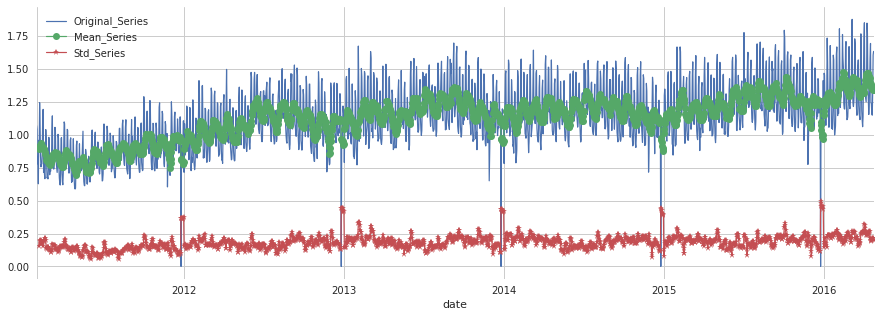


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -1.565373
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1886.000000
p-value: 0.500960
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
time_series_stationary_test(train_sales_cal_df[['avg_sales']])

A few keypoints from the graph and the Dickey-Fuller tests indicate that:

* Mean series is increasing with time and is not constant so series is not stationary
* Standard deviation series also has quite a few deivations which indicates that the time series is not stationary
* ADF statistic is larger than the critical value which indicates that the series still has a unit root


**Methods For Making Time Series Stationary**

Since the time series has both seasonality and trend components, we are going to adopt methods that would remove both trend and seasonality. Methods that we are going to use include:

* Differencing
* Decomposition

***Differencing***

In order to perform this let us first take log , perform a log difference between the time series and its lag and look at the results



In [ ]:
# tìm ra tập dữ liệu gía trị khác nhau dựa vào hiệu số của:
# giá trị logarit tự nhiên của tập giá trị avg_sales 
# giá trị logarit tự nhiên tính từ giá trị avg_sales, dịch chuyển đến 1 đơn vị 
df_log_diff = np.log(train_sales_cal_df[['avg_sales']]) - np.log(train_sales_cal_df[['avg_sales']]).shift()
#df['sold'] = df_log_diff
#df['sold'] = df['sold'].dropna()

# loại bỏ các giá trị rỗng, trong trường hợp này các dòng có giá trị avg_sales rông sẽ được loại bỏ trong tập dữ liệu tổng hợp
df_log_diff = df_log_diff.dropna()

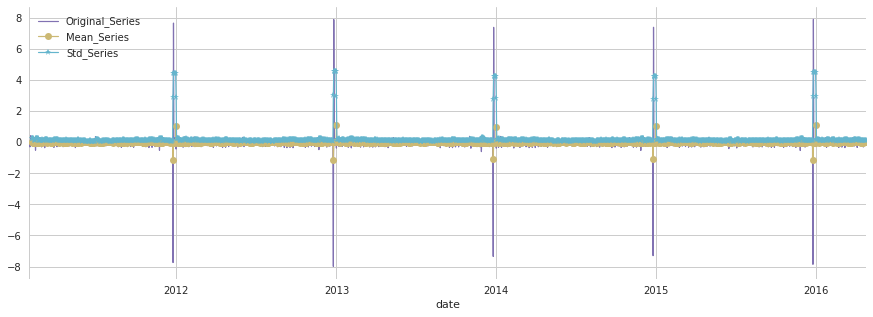


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -16.908187
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1885.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
# vẽ biểu đồ thể hiện sự khác nhau về dữ liệu avg_sales (doanh số bình quân) theo chuỗi thời gian
time_series_stationary_test(df_log_diff)


We can observe that the test statistic value is less than even 1 % of the critical value, which indicates that we can reject the null hypothesis (that series is non-stationary) with 99 % confidence and p_value of 0 indicates that the test result is significant.



***Decomposition***

Decomposition is another way to make the time series stationary. The decomposition of dataset yields three properties for the time series dataset

* Trend - That is whether there is an increase or decrease in total sales over long term
* Seasonality - Whether there are repeating patterns within the dataset
* Residual - What is the contribution of behavior in the time series dataset (total sales ) without trend and seasonality added


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# định nghĩa hàm vẽ đồ thị thể hiện phân tách dữ liệu theo chuỗi thời gian, bao gồm
# df: tập dữ liệu đầu vào cần khảo sát 
# model_specified: kiểu thuật toán tính dữ liệu
# period 
def time_series_decompose(df, model_specified, period):
    
    '''
    returns the trend, seasonality, and residual components decomposition of time_Series and
    plots the results 
    
    inputs: df(time_series df along with sales specified), model_specified (whether to use
            additive or multiplicative), period (number of days where seasonality 
            is to be observed)
    returns: decomposition plots along with decomposition components, in trend, seasonality
    and residuals
    '''

    # khởi tạo đối tượng DecomposeResult, bao gồm các giá trị biến số
    # x : tập dữ liệu xử lý, được đánh dấu index trên cột có tên date 
    # model: mô hình xử lý (phân bổ từ biến đầu vào)
    # period: số ngày tiến hành xử lý (phân bổ từ biến đầu vào)
    df_decomposition = seasonal_decompose(
                               x=df, 
                               model= model_specified, 
                               period=period)
    
    # phân tách dữ liệu xu hướng tổng quan theo chuỗi thời gian
    # thiết lập chỉ mục trên cột date
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')

    # phân tách dữ liệu theo mùa vị 
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')

    # phân tách dữ liệu thặng dư 
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    # khởi tạo biến đối tượng Figure và Axes, thực hiện trực quan hoá dữ liệu 
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 24))

    # thiết lập biểu đồ thể hiện dữ liệu 
    df.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax1)
    
    # phân bổ và thiết lập hiển thị dữ liệu xu hướng 
    est_trend.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax2)
    
    # phân bổ và thiết lập hiển thị dữ liệu mùa vị 
    est_seasonal.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax3)
    

    # phân bổ và thiết lập hiển thị dữ liệu thặng dư 
    est_residual.plot(figsize=(14, 8) ,
                 alpha=0.6, 
                 lw=3, style = 'o', ax = ax4)

    # vẽ biểu đồ
    fig.tight_layout()
    plt.show()
    
    return est_trend, est_seasonal, est_residual

#sample_time_s1 = train_sales_cal_df[400:700]
#est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 'multiplicative', 15)


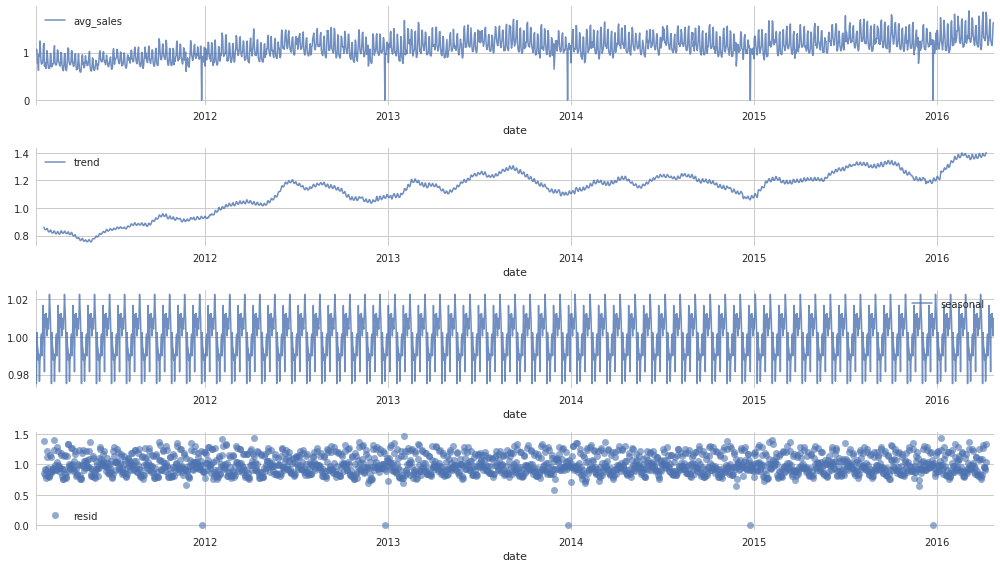

In [ ]:
#print(train_sales_cal_df[['avg_sales']]);

# vẽ biểu đồ thể hiện xu hướng phát triển của doanh số, tình hình doanh số trung bình theo mùa vị, độ thặng dư theo chuỗi thời gian 
# đồng thời gán các tập dữ liệu giá trị xu hướng phát triển, mùa vị, độ thặng dư vào các biến
trend_comp, seas_comp, residual_comp = time_series_decompose(train_sales_cal_df[['avg_sales']], 'multiplicative', 30)

The above results indicate that the presence of an increasing trend, as well as high seasonality in the time series being observed. The residuals are infact the component of the time series without the seasonality and trend.


Let's see what the results of the dickey-fuller test in decomposition are


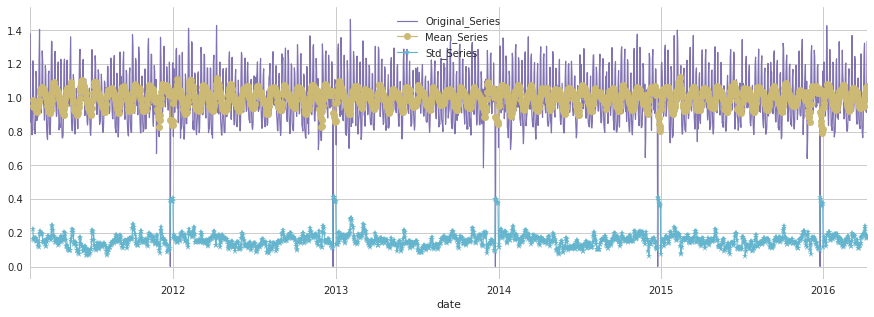


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -26.316735
No of lags: 25.000000
No of Obs used for ADF Calculation & Critical Values: 1857.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
# loại bỏ các giá trị rỗng trong tập thặng dư
residual_comp = residual_comp.dropna()
time_series_stationary_test(residual_comp)

The test statistic is less than 1 % of the critical value so we reject the null hypothesis with 99 % confidence and therefore, the time series is stationary



## SARIMAX

SARIMAX (Seasonal Auto-Regressive Integrated Moving Averages With Exogenous Factors) is an extension of the ARIMA model but one that is able to handle the seasonality component along with exogenous factors. i.e. holidays.

ARIMA forecasting for a stationary time series is nothing but a regression equation. The prediction on the arima model is determined by its 'Trend' parameters p,d and q. They represent:

* Number of AR (auto-regressive) terms (p) : AR terms are just lags of the dependent variable. e.g. if p is 2, the predictors for x(t) will be x(t-1), x(t-2) OR AR terms view the value at one time as a weighted sum of past values.
* Number of MA (moving averages) terms (q) : MA terms are lagged forecast errors e(i) in prediction equation where e(i) is the difference between the moving avg at ith term vs the actual value. For q = 2, the predictors for x(t) will be e(t-1), e(t-2).
* Number of differences (d) : These are the number of non-seasonal differences.

The SARIMAX adds other seasonal components to handle the seasonality with P, D, Q and m represpresenting the seasonal 'Auto-regressive' 'Differencing' and 'Moving-Average' Orders with m representing the number of time steps that are observing the seasonal behaviour.

The equation for SARIMAX is given as SARIMAX (p, d, q) = (P, D, Q, S)

To find out the appropriate values for p and q, we generally employ ACF (auto-correlation function) and PCF (Partial-correlation function).

* **ACF** - AutoCorrelationFunction: It is the measure of the correlation of a time series against lagged version of itself. e.g. with a lag of 3, ACF would compare the time instances t1, t2 with t1-3, t2-3
* **PCF** - PartialCorrelationFunction: It is a measure of correlation of a time series against a lagged version of itself but after removing the already calculated variations. e.g. with a lag of 4, PCF would check the correlation of against the lagged version but after removing the effects explained by lag1 to lag3




In [ ]:
# tìm ra tập dữ liệu gía trị khác nhau dựa vào hiệu số của:
# giá trị logarit tự nhiên của tập giá trị avg_sales 
# giá trị logarit tự nhiên tính từ giá trị avg_sales, dịch chuyển đến 1 đơn vị 
df_log_diff = np.log(train_sales_cal_df['avg_sales']) - np.log(train_sales_cal_df['avg_sales']).shift()

# loại bỏ giá trị rỗng trong tập dữ liệu vừa tổng hợp 
df_log_diff = df_log_diff.dropna()

### ACF & PACF: Finding Pdq Visually?

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

# định nghĩa hàm vẽ biểu đồ, bao gồm 
# ts_stat: tập dữ liệu cần khảo sát theo định dạng chuỗi thời gian
def auto_par_corr(ts_stat, nlags=25): 

    '''
    returns the ACF and PACF plots of the time series
    
    inputs: ts_stat (time series along with data), nlags (optimal number of lags)
    
    returns: plot of ACF and PACF
    '''
    lag_acf = acf(ts_stat, nlags)
    lag_pacf = pacf(ts_stat, nlags, method='ols')
    
    sns.set_style("whitegrid")

    
    plt.figure(figsize=(15, 8))
    plt.subplot(121)
    #plt.plot(lag_acf)
    plt.stem(lag_acf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Auto-Correlation')
    
    #lag_pacf.plot(figsize=(15, 5), alpha=1, 
    #                    lw=3, color=next(color_cycle), label='par_corr', ax=ax2)
    plt.subplot(122)
    #plt.plot(lag_pacf)
    plt.stem(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Partial Auto-Correlation')
    
    plt.legend()
    plt.show()


In [ ]:
auto_par_corr(df_log_diff, nlags=25)

NameError: ignored

A couple of things of note here are :

* In the first plot of autocorreation, the first significant value occurs at between 1 and 2, so therefore we are going to select q=1, while in the second plot of PACF, the significant value occurs at 2 so p=2
* In the ACF plot, we have regular peaks at interval of 7 so we are going to select the value of parameter m in seasonal order as 7, and since this lag is positive therefore the value for P=1, and for Q=0.
* As for value of d (differencing), we are going to select d as being 1 since we have taken a first order differencing, and since our seasonal pattern in ACF plot is stable we are going to choose value of D=1 (as opposed to D=0 when seasonal pattern is unstable)


In [ ]:
#train_sales_cal_df.index = pd.DatetimeIndex(train_sales_cal_df.index.values,
# 

In [ ]:
#Let us split the time series into training and testing sets
#perc_training = 0.7
#split_p = round(len(train_sales_cal_df['avg_sales']) * perc_training)
#training_p, testing_p = train_sales_cal_df['avg_sales'][0:split_p], train_sales_cal_df['avg_sales'][split_p:]

# trích xuất từ vị trí đầu tiên đến dòng có giá trị 2015-10-14, và chỉ lấy giá trị cột avg_sales
training_p = train_sales_cal_df.loc[:'2015-10-14', ['avg_sales']]

# trích xuất từ vị trí đầu tiên đến dòng có giá trị 2015-10-15, và chỉ lấy giá trị cột avg_sales
testing_p = train_sales_cal_df.loc['2015-10-15':, ['avg_sales']]
training_p.head(2)

In [ ]:
tmp = calendar_df.copy()

tmp 
#print(tmp[~tmp['event_name_1'].isna()]['date'])
#tmp1 = tmp[~tmp['event_name_1'].isna()]
#tmp1

**Making Exogeneous Factors**

In [ ]:
#for prophet model:
# trích xuất dữ liệu từ tập calendar_df, chỉ lấy giá trị từ cột date với điều kiện cột event_name_1 không rỗng (NaN)
# xây dựng thành 1 đối tượng DataFrame thể hiện tập dữ liệu bao gồm 2 cột
### holiday  = Event 1
### ds = danh sách được trích xuất
df_event_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': calendar_df[~calendar_df['event_name_1'].isna()]['date']})

# trích xuất dữ liệu từ tập calendar_df, chỉ lấy giá trị từ cột date với điều kiện cột event_name_2 không rỗng (NaN)
# xây dựng thành 1 đối tượng DataFrame thể hiện tập dữ liệu bao gồm 2 cột
### holiday  = Event 1
### ds = danh sách được trích xuất
df_event_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': calendar_df[~calendar_df['event_name_2'].isna()]['date']})

# trích xuất dữ liệu từ tập calendar_df, chỉ lấy giá trị từ cột date với điều kiện cột snap_CA =1
# xây dựng thành 1 đối tượng DataFrame thể hiện tập dữ liệu bao gồm 2 cột
### holiday  = snap_CA
### ds = danh sách được trích xuất
df_snapca = pd.DataFrame({'holiday': 'snap_CA', 'ds': calendar_df[calendar_df['snap_CA'] == 1]['date']})

# trích xuất dữ liệu từ tập calendar_df, chỉ lấy giá trị từ cột date với điều kiện cột snap_TX =1
# xây dựng thành 1 đối tượng DataFrame thể hiện tập dữ liệu bao gồm 2 cột
### holiday  = snap_TX
### ds = danh sách được trích xuất
df_snaptx = pd.DataFrame({'holiday': 'snap_TX', 'ds': calendar_df[calendar_df['snap_TX'] == 1]['date']})

# trích xuất dữ liệu từ tập calendar_df, chỉ lấy giá trị từ cột date với điều kiện cột snap_WI =1
# xây dựng thành 1 đối tượng DataFrame thể hiện tập dữ liệu bao gồm 2 cột
### holiday  = snap_WI
### ds = danh sách được trích xuất
df_snapwi = pd.DataFrame({'holiday': 'snap_WI', 'ds': calendar_df[calendar_df['snap_WI'] == 1]['date']})

# tổng hợp dữ liệu, nối toàn bộ tập dữ liệu thành 1
holidays = pd.concat((df_event_1, df_event_2, df_snapca, df_snaptx, df_snapwi))
holidays.head(3)

In [ ]:
#ever since spliting exo, it is to be added additionally

# chuyển đổi kiểu dữ liệu của giá trị cột ds thành DateTime
holidays['ds'] = pd.to_datetime(holidays['ds'])

In [ ]:
# for SARIMAX Model:

# xây dựng tập dữ liệu data, bao gồm các thành phần
### date: trích xuất từ danh sách giá trị cột đang là chỉ mục của tập dữ liệu train_sales_cal_df (lúc này là cột date)
### holidays : 0
data = {'date':train_sales_cal_df.index,
        'holidays': 0 }

# xây dựng đối tượng DataFrame được phân bổ dữ liêu từ tập dữ liệu data 
exo = pd.DataFrame(data)

# phân bổ dữ liệu cho cột holidays cho tập dữ liệu exo, 
# bằng cách tìm kiếm xem giá trị cột date của tập dữ liệu exo có tồn tại trong tập dữ liệu holidays đã được trích xuất và tổng hợp bên trên hay không 
# đánh gía trị = 1 nếu như thoã điều kiện tìm kiếm 
for idx, date1 in enumerate(exo['date']):
    for date2 in holidays['ds']:
        if date2 == date1:
            exo['holidays'].iloc[idx] = 1
        else:
            continue  

In [ ]:
# thực hiện đánh chỉ mục tập dữ liệu exo trên cột date
exo = exo.set_index(['date']).asfreq('D')
exo.head(4)

In [ ]:
# trích xuất dữ liêu từ tập exo vào exo_train, từ vị trí bắt đầu của chỉ mục (hiện đang là cột date), đến vị trí giá trị '2015-10-14'
exo_train = exo.loc[:'2015-10-14']

# trích xuất dữ liêu từ tập exo vào exo_train, từ vị trí có gía trị '2015-10-15' của chỉ mục (hiện đang là cột date), đến vị trí cuối cùng
exo_test = exo.loc['2015-10-15':]

In [ ]:
#Conversion into Series according to SARiMAX req:
#conversion into timeseries if required, for now there is neither benefit nor requirement
#exo_train = pd.Series(exo_train.iloc[:, 0])
#exo_test = pd.Series(exo_test.iloc[:, 0])

In [ ]:
# định nghĩa hàm phân tích và thể hiện dữ liệu theo mô hình SARIMAX
def SARIMAX_tune(ts, total_params):

    '''
    returns the optimal tuned results using AIC as a prediction accuracy metric
    
    inputs : ts (time series), total_params (SARIMAX models parameters to be specified)
    
    returns: results of SARIMAX tuned model
    '''
    results = []

    for param in total_params:
        try:
            model = SARIMAX(ts, exog = exo, order=param[0], seasonal_order=param[1], 
                           initialization='approximate_diffuse')
            res = model.fit(method='powell')
            results.append((res, res.aic, res.params))
            print("The results of SARIMAX{}x{} in AIC are: {}".format(param[0], param[1], res.aic))
        except Exception as e:
            print(e)
            continue
    
    return results

In [ ]:
###########New Code#############
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

def SARIMAX_tune_with_RMSE(ts, total_params):
    
    '''
    returns the optimal tuned results using RMSE as a prediction error metric
    
    inputs : ts (time series), total_params (SARIMAX models parameters to be specified)
    
    returns: results of SARIMAX tuned model with RMSE as the error metric
    '''
    tscv = TimeSeriesSplit(n_splits = 5)
    rmse_array = []
    timeseries = ts #train_sales_cal_df[['avg_sales']]
    results = []
    
    for train_index, test_index in tscv.split(timeseries):
        cv_train, cv_test = timeseries.iloc[train_index], timeseries.iloc[test_index]
        
        for param in total_params:
            try:
                model = SARIMAX(cv_train, order=param[0], seasonal_order=param[1], 
                               initialization='approximate_diffuse')
                res = model.fit(method="powell")
                results.append((res, res.params))
                #use this statement for further troubleshooting on mle #print("MLE retvals for this iter are: {}".format(res.mle_retvals))
                #print("The results of SARIMAX{}x{} in are: {}".format(param[0], param[1]))
            except Exception as e:
                print(e)
                continue

            sarimax = model.fit(disp=0)
            predictions = sarimax.predict(cv_test.index.values[0], cv_test.index.values[-1])
            true_values = cv_test.values
            #true_values = cv_test
            #wrmse_array.append(wrmse(true_values, predictions))
            #rmse_array.append(np.sqrt(mean_squared_error(true_values, predictions)))
            print("Results of SARIMAX in {} x {} in RMSE: {}".format(param[0], param[1], 
                                                                 np.sqrt(mean_squared_error(true_values, predictions))))
        
        return results

### The Accuracy Metric AIC:

Since the **AIC (Akaike-Information Criterion)** is given by the difference of number of paramters vs log-likelihood of the model, it is therefore desirable to select the values of AIC that are as small (or in the current case) as negative as possible. The formula for the AIC is :
* **AIC = 2K - ln(k)**

where k is the number of parameters for the selection of the model

Since the combination for pdq in our case tends to come out as 2,1,1 and for seasonal_PDQ as 0,1,2,7 Therefore, we are going to select those values





### Validation SARIMAX


In [ ]:
p, d, q =range(1,3), [1], range(1,3)
P, D, Q, S =range(0,3), [1], range(1,3), [7]
pdq = list(itertools.product(p,d,q))
seasonal_pdq = list(itertools.product(P,D,Q,S))
total_params = list(itertools.product(pdq, seasonal_pdq))

#NOTE: memory intensive operation if range set at 0,3, readings have already been taken by running it once:
#all_results = SARIMAX_tune(train_sales_cal_df['avg_sales'], total_params)
#all_results = SARIMAX_tune_with_RMSE(train_sales_cal_df[['avg_sales']], total_params)

#More information regarding fixng the error nle_retvals can be found at:
#https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax

In [ ]:
#all_results = SARIMAX_tune_with_RMSE(train_sales_cal_df[['avg_sales']], total_params)


In [ ]:
#######NOTE: THIS WAS THE MISTAKE THAT WAS STOPPING TIMESERIES GRAPHS FROM RENDERGIN#####
#train_sales_cal_df.index = pd.to_datetime(train_sales_cal_df.index)
#type(train_sales_cal_df.index)

                                     SARIMAX Results                                     
Dep. Variable:                         avg_sales   No. Observations:                 1720
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood                1485.773
Date:                           Sat, 22 Oct 2022   AIC                          -2957.546
Time:                                   14:37:29   BIC                          -2919.494
Sample:                               01-29-2011   HQIC                         -2943.457
                                    - 10-14-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3601      0.013     26.946      0.000       0.334       0.386
ar.L2          0.1133      0.022      5.088

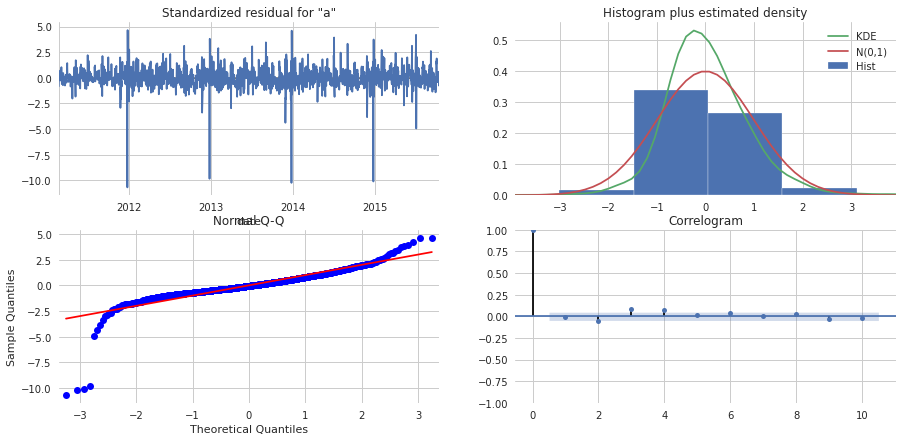

In [ ]:
#Fitting in the SARIMAX Model
#include the exo_train in here , exo_test in prediction (model_fit_SARIMAX) to check results: for now, abandoning their use because
# of the error in package, since even converting exo_train, exo_test into time series/using df results
# in errors. 
#model values earlier 1,1,1, 0,1,1,7 
#values with RMSE - order=(2,1,1), seasonal_order=(2,1,1,7), 
model = SARIMAX(training_p,
                order=(2,1,1), seasonal_order=(2,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(15,7))
plt.show()
#information on whether particular model is a goodfit
#https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

The above plots confirm the inferences of the following information:

* The first left plot shows that residual errors fluctuate around a mean of zero and have uniform variance
* The first right plot indicates that density plot also has a mean of almost zero
* The second left plot indicate an almost a perfect fit on red line pointing to the fact that distribution is not skewed
* The low auto-correlation of residuals is indicated in the second right plot.


### SARIMAX Graphical Validation & Forecasting

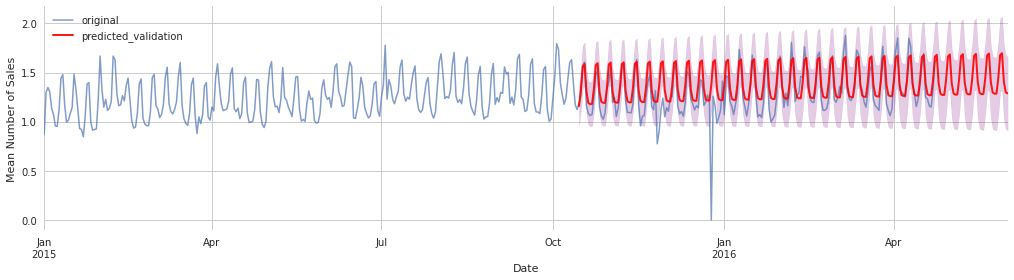

In [ ]:
def model_fit_SARIMAX(model_set, model_fit_srt_tm='2015-10-15', ts_st_tm='2013'):
    
    '''
    makes predictions using SARIMAX model tuned earlier and returns plots along with 
    predictions made
    
    inputs: model_set (model tuned), model_fit_srt_tm (model prediction starting time), 
            ts_st_tm (time series plot to be plotted beginning point)
    returns: forecast plot along with time_series, and pred (predictions made series)
    
    '''
    
    #1.# pred = model_fit.forecast(len(testing_p), alpha=0.05, dynamic=False)  # 95% conf
    pred = model_set.get_prediction(start=pd.to_datetime(model_fit_srt_tm), end='2016-06-01', dynamic=False)
    pred_conf = pred.conf_int()
    #for dynamic prediction of time_series:
    #pred_dy = model_set.get_prediction(dynamic=pred_srt_tm)
    #pred_dy_conf = pred_dy.conf_int()

    # Make as pandas series
    #pred_series = pd.Series(pred, index=testing_p.index)

    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))

    train_sales_cal_df['avg_sales'][ts_st_tm:].plot(label='original',
                                                  alpha=0.7, 
                                                  lw=1.5 , ax=ax1)
    pred.predicted_mean.plot(label='predicted_validation',
                             alpha=0.9, color='red',
                             lw=2, ax=ax1)
    ax1.fill_between(pred_conf.index, 
                     pred_conf.iloc[:,0], 
                     pred_conf.iloc[:, 1], color='purple', alpha=0.2)
    fig.tight_layout()
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Number of Sales')
    plt.legend(loc='upper left')
    plt.show()
    
    return pred

pred_made = model_fit_SARIMAX(model_fit, ts_st_tm='2015')    


Looking at the above graphical representation, we can see that:

* our model (indicated by green line) provides quite a good enough approximation for modeling the time_series behavior with the maroon background indicating a confidence interval for the new predicted time series.
* We have applied the model on the test_dataset (data already present in our time series). In the next step, we would try to predict this time series response in the future


In [ ]:
#def forecast_error(prediction, original, date, col):
#    
#    '''
#    returns the Mean Absolute Error (MAE) and root mean square error (RMSE)
#    
#    inputs: prediction (forecasted series, with dates as predicted above), original (orginal time series df), 
#            date (where the model was started for forecast), col(column with time_series_values)
#    
#    returns : MAE, and RMSE 
#    '''
#    forecasted = prediction.predicted_mean
#    original = original.loc[date:, col]
#
#    MAE = np.abs(forecasted - original).mean()
#    RMSE = np.sqrt(((forecasted - original)**2).mean())
#
#    print("The mean absolute error is : {}".format(MAE))
#    print("The root mean square error is : {}".format(RMSE))
#
#
#forecast_error(pred_made, testing_p, '2015-10-15', 'avg_sales')    


In [ ]:
#fitting the model once again now to all the timeseries data (train_sales_cal_df['avg_sales']) available:
#old_values - 2,1,1 & 0,1,2,7
model = SARIMAX(train_sales_cal_df['avg_sales'],
                order=(2,1,1), seasonal_order=(2,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)

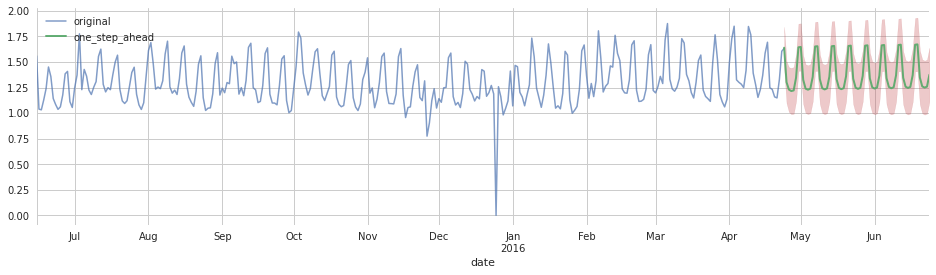

In [ ]:
#Making Future Prediction:
#note: exo_sub = exo.loc['2016-01-25':], if it is needed to provide the holidays , equate exo_sub to exog in get forecast

#pred_future = model_fit.get_forecast(steps=90) #Making Prediction for next 3 months

pred_future = model_fit.get_prediction(start='2016-04-24', end='2016-06-24', dynamic=False)
pred_f_conf = pred_future.conf_int()

fig, ax2 = plt.subplots(figsize=(16, 4))


#now using the entire original series, instead of training or testing:

train_sales_cal_df['avg_sales']['2015-06-15':].plot(label='original',
                 alpha=0.7, 
                 lw=1.5 , color=next(color_cycle), ax=ax2)

pred_future.predicted_mean.plot(label='one_step_ahead',
                 alpha=0.9, 
                 lw=2, color=next(color_cycle), ax=ax2)

ci = pred_f_conf.loc['2016-04-24':]

ax2.fill_between(ci.index, 
                ci.iloc[:,0], 
                ci.iloc[:, 1], color=next(color_cycle), alpha=0.3)

plt.legend(loc='upper left')
plt.show()


The 'original' label represents the timeseries data for which we have the data of average sales available. Whereas the 'one_ahead_label' indicates the forecast made for the time series of average sales, AND the filled background indicates the confidence interval.


The Forecast is a fairly good response of average number of sales that would be made into the future.



### WRMSSE Calculation

In order to measure the performance of the model, the competition metric has been provided already. This competiton metric can be found at the guidlines provided in the following link.


WRMSSE is a sales metric that derives itself from RMSSE metric which is a variation on the metric of MASE (mean absolute scaled error). RMSSE specifically evaluate the sales forecast for datasets where heirarchical data level is made available. Since the first dataset of train_sales_val has heirarchical sales data available (i.e.sales divided along product_ids, item_ids, dept_ids, and store_ids level) and one that is also intermittent (i.e. has greater incidence of zero sales in some days while significant sales in other days), RMSSE's utility makes sense. The RMSSE metric also penalizes too large or too small values, therefore it is symmetric.



In [ ]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

calendar_df = reduce_mem_usage(calendar_df)

sell_prices_df = reduce_mem_usage(sell_prices_df)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [ ]:
from scipy.sparse import csr_matrix
import gc

NUM_ITEMS = train_sales_df.shape[0]  # 30490
DAYS_PRED = submission_file.shape[1] - 1  # 28

# Dataframe with only last 28 days:
sales = train_sales_df

# xây dựng tập dữ liệu cols với ý định chưa toàn bộ giá trị date trong vòng 28 ngày, bắt đầu từ 1914
# kết quả hàm này sẽ cho ta 1 tập dữ liệu d_1914, d_1915...
cols = ["d_{}".format(i) for i in range(1914-28, 1914)]

# trích xuất dữ liệu từ tập sales, tập dữ liệu mới sẽ bao gồm cột id, store_id, item_id và các cột có tiền tố d_x được phân bổ từ danh sách cols
data = sales[["id", 'store_id', 'item_id'] + cols]


# To long form:
# chuyển đổi định dạng của tập dữ liệu data, biến đổi từ định dạng chiều ngang > dọc 
# cụ thể các cột được định nghĩa trong biến id_vars được xác định là thuộc tính cần được mô tả
# các cột còn lại (là các cột có tiền tố d_x) được chuyển đổi thành giá trị thuộc tính của bộ id_vars, và được đặt tên là d,
# giá trị các cột này vẫn giữ nguyên và đặt tên là sale
data = data.melt(id_vars=["id", 'store_id', 'item_id'], 
                 var_name="d", value_name="sale")

# Add week of year column from 'calendar':
# tổng hợp dữ liệu, tiến hành kết hợp dữ liệu data với tập dữ liệu calendar_df trên trường d 
# tập dữ liệu mới được tổng hợp sẽ bao gồm toàn bộ dữ liệu của 2 tập data và calendar, khớp với nhau dựa vào giá trị cột d 
data = pd.merge(data, calendar_df, how = 'left', 
                left_on = ['d'], right_on = ['d'])

# trích xuất dữ liệu, lấy ra danh sách dữ liệu từ các cột id, store_id, item_id, sale, d, wm_yr_wk
data = data[["id", 'store_id', 'item_id', "sale", "d", "wm_yr_wk"]]

# Add weekly price from 'sell_prices':
# tổng hợp dữ liệu, tiến hành kết hợp dữ liêu với tập sale_prices_df trên các khoá store_id, item_id, wm_yr_wk 
# vì tiến hành dựa trên phương thức LEFT, trường hợp đata không có khoá khớp với sell_prices_df, dòng dữ liệu vẫn không bị remove, chỉ xuất hiện các giá trị (từ các cột của sell_prices_df) là rỗng
data = data.merge(sell_prices_df, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')

# chuẩn hoá dữ liệu, loại bỏ cột wm_yr_wk
data.drop(columns = ['wm_yr_wk'], inplace=True)

# Calculate daily sales in USD:
# tổng hợp dữ liệu, giá trị côt dữ liệu mới được tổng hợp bằng TÍCH của sale - sell_price
# đặt tên là sale_usd
data['sale_usd'] = data['sale'] * data['sell_price']
data.head()

#this part is correct

,id,store_id,item_id,sale,d,sell_price,sale_usd
0,HOBBIES_1_001_CA_1_validation,CA_1,HOBBIES_1_001,1,d_1886,8.26,8.26
1,HOBBIES_1_002_CA_1_validation,CA_1,HOBBIES_1_002,1,d_1886,3.97,3.97
2,HOBBIES_1_003_CA_1_validation,CA_1,HOBBIES_1_003,0,d_1886,2.97,0.00
3,HOBBIES_1_004_CA_1_validation,CA_1,HOBBIES_1_004,0,d_1886,4.64,0.00
4,HOBBIES_1_005_CA_1_validation,CA_1,HOBBIES_1_005,1,d_1886,2.88,2.88


In [ ]:
# List of categories combinations for aggregations as defined in docs:
# tạo ra 1 danh sách với các phần tử được trích xuất từ các giá trị tập dữ liệu sales 
dummies_list = [sales.state_id, sales.store_id, 
                sales.cat_id, sales.dept_id, 
                sales.state_id +'_'+ sales.cat_id, sales.state_id +'_'+ sales.dept_id,
                sales.store_id +'_'+ sales.cat_id, sales.store_id +'_'+ sales.dept_id, 
                sales.item_id, sales.state_id +'_'+ sales.item_id, sales.id]


## First element Level_0 aggregation 'all_sales':
# tạo ra 1 danh sách với các phần tử được phân bổ như sau
### tạo ra 1 mảng danh sách các có chiều dài = chiều dài tập dữ liệu sale, toàn bộ phần tử được fill in = 1
### đánh chỉ mục bằng chỉ mục hiện tại của tập sales
### chuyển đổi mảng danh sách thành kiểu dữ liệu DataFrame, sau đó đổi chiều tập dữ liệu theo đường chéo 
dummies_df_list =[pd.DataFrame(np.ones(sales.shape[0]).astype(np.int8), 
                               index=sales.index, columns=['all']).T]

# List of dummy dataframes:
for i, cats in enumerate(dummies_list):
    dummies_df_list +=[pd.get_dummies(cats, drop_first=False, dtype=np.int8).T]
    
# Concat dummy dataframes in one go:
## Level is constructed for free.
roll_mat_df = pd.concat(dummies_df_list, keys=list(range(12)), 
                        names=['level','id'])#.astype(np.int8, copy=False)

# Save values as sparse matrix & save index for future reference:
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
roll_mat_csr.shape

(42840, 30490)

In [ ]:
roll_mat_df.to_pickle('roll_mat_df.pkl')
del dummies_df_list, roll_mat_df
gc.collect()

491

In [ ]:
# Fucntion to calculate S weights:
def get_s(drop_days=0):
    
    """
    drop_days: int, equals 0 by default, so S is calculated on all data.
               If equals 28, last 28 days won't be used in calculating S.
    """
    # Rollup sales:
    d_name = ['d_' + str(i+1) for i in range(1913-drop_days)]
    sales_train_val = roll_mat_csr * sales[d_name].values

    no_sales = np.cumsum(sales_train_val, axis=1) == 0
    sales_train_val = np.where(no_sales, np.nan, sales_train_val)

    # Denominator of RMSSE / RMSSE
    weight1 = np.nanmean(np.diff(sales_train_val,axis=1)**2,axis=1)
    
    return weight1

In [ ]:
S = get_s(drop_days=0)
S.shape

In [ ]:
# Functinon to calculate weights:
def get_w(sale_usd):
    """
    """
    # Calculate the total sales in USD for each item id:
    total_sales_usd = sale_usd.groupby(
        ['id'], sort=False)['sale_usd'].apply(np.sum).values
    
    # Roll up total sales by ids to higher levels:
    weight2 = roll_mat_csr * total_sales_usd
    
    return 12*weight2/np.sum(weight2)

In [ ]:
W = get_w(data[['id','sale_usd']])
W.shape

In [ ]:
# Predicted weights
##W_df = pd.DataFrame(W,index = roll_index,columns=['w'])

# Load the original weights:
##data_pass = '/kaggle/input/original-weights/'
##W_original_df = pd.read_csv(data_pass+'weights_validation.csv')

# Set new index, calculate difference between original and predicted:
##W_original_df = W_original_df.set_index(W_df.index)
##W_original_df['Predicted'] = W_df.w
##W_original_df['diff'] = W_original_df.Weight - W_original_df.Predicted

# See where we are off by more than e-6
##m = W_original_df.Weight.values - W_df.w.values > 0.000001
##W_original_df[m]

In [ ]:
SW = W/np.sqrt(S)
sw_df = pd.DataFrame(np.stack((S, W, SW), axis=-1),index = roll_index,columns=['s','w','sw'])
sw_df.to_pickle('sw_df.pkl')

In [ ]:
# Function to do quick rollups:
def rollup(v):
    '''
    v - np.array of size (30490 rows, n day columns)
    v_rolledup - array of size (n, 42840)
    '''
    return roll_mat_csr*v #(v.T*roll_mat_csr.T).T


# Function to calculate WRMSSE:
def wrmsse(preds, y_true, score_only=False, s = S, w = W, sw=SW):
    '''
    preds - Predictions: pd.DataFrame of size (30490 rows, N day columns)
    y_true - True values: pd.DataFrame of size (30490 rows, N day columns)
    sequence_length - np.array of size (42840,)
    sales_weight - sales weights based on last 28 days: np.array (42840,)
    '''
    
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds.values-y_true.values))
                            ,axis=1)) * sw)/12 #<-used to be mistake here
    else: 
        score_matrix = (np.square(rollup(preds.values-y_true.values)) * np.square(w)[:, None])/ s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix,axis=1)))/12 #<-used to be mistake here
        return score, score_matrix

### Prophet Time Series Modeling

Prophet is a time-series forecasting tool developed by facebook team that has advanced capabilities to predict the time series data taking into consideration the weekly, monthly or yearly data seasonality. Prophet also has advanced capability to implement custom changepoints observed in time series data as well as specify holiday points where trends are continuously changing.



In [ ]:
#dates_s = [pd.to_datetime(calendar_df.loc[calendar_df['d'] == str_date,'date'].values[0]) for str_date in d_cols]


In [ ]:
#df_sale_group_item = train_sales_df[np.hstack([['dept_id','store_id'],d_cols])].groupby(['dept_id','store_id']).sum()
#df_sale_group_item = df_sale_group_item.reset_index()

#item_series =  df_sale_group_item[(df_sale_group_item.dept_id == 'FOODS_1') & (df_sale_group_item.store_id == 'TX_1')]
#dates = pd.DataFrame({'ds': dates_s}, index=range(len(dates_s)))
#dates['y'] = item_series[d_cols].values[0].transpose() 

**Fb Prophet: Training and Validation Data Split**

In [ ]:
#prophet forecast from here
from fbprophet import Prophet
from tqdm.notebook import tqdm as tqdm

####Observing behavior of Avg Number of Sales using Prophet#######
####Converting the data into required ds and y format for Prophet Model#####

ts = train_sales_cal_df[['avg_sales']].reset_index()
ts = ts.set_axis(['ds', 'y'], axis=1, inplace=False)

#####Specifying data for only one year to better visulize future predictions#######
threshold_date = pd.to_datetime('2015-04-22') 
select_d = ts ['ds'] > threshold_date

ts = ts[select_d][['ds', 'y']]

#####prophet_plot(ts)######

mod_params = { 'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 
sales_model = Prophet(**mod_params, interval_width=0.95)
#data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used

######fitting the prophet model########

sales_model.fit(ts)
future = sales_model.make_future_dataframe(28, 'D')
#future['cap'] = data['cap'].max() #incase logistic model growth used in params
sales_forecast = sales_model.predict(future)

########Train/Test split of Data#######################

threshold_date = pd.to_datetime('2016-03-01') #for the test/validation split
forecast_date = pd.to_datetime('2016-04-24') #for the actual forecast date to begin
select_d = ts ['ds'] < threshold_date

ts_train = ts[select_d][['ds', 'y']]
ts_test = ts[~ select_d][['ds', 'y']]

select_d2 = sales_forecast['ds'] < forecast_date


forecast_train = sales_forecast[select_d2]
forecast_test = sales_forecast[~ select_d2]

**Prophet Forecasting On Average Sales Using Seaborn**

In [ ]:
#Seaborn based plot for the fb_Prophet Model
sns.set_style('whitegrid')
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(15,5))

ax.fill_between(
    x=sales_forecast['ds'], y1=sales_forecast['yhat_lower'], y2=sales_forecast['yhat_upper'],
    color=sns_c[2],  alpha=0.25, label=r'95% confidence_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=ts_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=ts_test, ax=ax)
#sns.lineplot(x='ds', y='yhat', label='y_hat', data=sales_forecast, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.axvline(forecast_date, color='g', linestyle='--', label='train test split')

ax.legend(loc='lower left')
ax.set(title='Avg Sales of Units', ylabel='');

The above plot indicates the prophet model forecasting using average number of sales as a dependent variable. The plot indicatest that:

* y_train(blue line plot) represents the training set data
* y_test (green line ) is representative of validation data response
* y_hat (red line) is a modeled response obtained using the Prophet Prediction Model
* green filled area represents the 95 % confidence interval for the plot

**Prophet Forecast Using Individual Product IDs**

In [ ]:
#selecting the product ids for which we require prophet prediction

id1 = 'FOODS_3_443_CA_1_validation'
id2 =  'HOUSEHOLD_1_005_CA_3_validation'
id3 =  'FOODS_3_823_WI_3_validation'
id4 = 'FOODS_3_090_CA_3_validation'
id5 = 'FOODS_3_586_TX_2_validation'
id6 = 'FOODS_3_586_TX_3_validation'

#train_sales_cal_df[id2]

In [ ]:
def make_id_timeseries(idx, date='2016-02-22'):
    
    '''
    selects and makes the timeseries adjusted for fb prophet model by adjusting names
    of columns
    
    inputs: product_id
    
    returns: time series with data specified in format for prophet
    
    '''
    
    dates_series = [date for date in train_sales_cal_df.index]
    id_series =  train_sales_df[(train_sales_df.id == idx )]
    item_ts = pd.DataFrame({'ds': dates_series}, index=range(len(dates_series)))
    item_ts['y'] = id_series[d_cols].values[0].transpose()
    
    ######Following steps would shorten the behavior of historic timeline data########
    ######Choosing the threshold date near to the date where prediction needs to be made 
    ######because of close correlation in time series
    
    threshold_date = pd.to_datetime(date) 
    mask = item_ts['ds'] > threshold_date

    item_ts = item_ts[mask][['ds', 'y']]
    
    return item_ts

data1 = make_id_timeseries(id6)
data4 = make_id_timeseries(id4)

In [ ]:
#weighted_coeff = (df_cv['yhat'] - df_cv['y'])/(df_cv['yhat'] - df_cv['y']).mean()
#e = ((df_cv['yhat'] - df_cv['y']) * weighted_coeff )/ (weighted_coeff*df_cv['y'])
#resulting_wmape = pd.DataFrame(df_cv['yhat'], df_cv['y'], weighted_coeff, e)
##print("yhat:{}, actual:{}, coeff:{}, error:{}".format(df_cv['yhat'], df_cv['y'], weighted_coeff, e))
#data = {'yhat':list(df_cv['yhat']),
#        'actual':list(df_cv['y']),
#        'diff' : list(df_cv['yhat'] - df_cv['y']),
#       'weighted_coef': list(weighted_coeff), 
#       'error': list(e)}
#  
# Create DataFrame
#pd.DataFrame(data)

**Custom Loss Function For Fb Prophet Tuning**

In [ ]:
##########New Code Working For Custom Error###########
import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Note : the code was generated using the explanation at the following link
#https://www.baeldung.com/cs/mape-vs-wape-vs-wmape

def fbprophet_tuning_per_single_id(id_data, changepoint_prior_list=[0.5, 0.6, 0.7], 
                                   changepoint_range_list=[0.6, 0.7, 0.8], 
                                   n_changepoints_list=[50, 60]):
    param_grid = {  
        'changepoint_prior_scale': changepoint_prior_list,
        'changepoint_range': changepoint_range_list,
        'n_changepoints' : n_changepoints_list
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    #wapes = []  # Store the RMSEs for each params here
    wmapes = []

    # Use cross validation to evaluate all parameters
    for params in all_params:
        mod = Prophet(**params).fit(id_data)  # Fit model with given params
        df_cv = cross_validation(mod, initial = '32 days', period = '3 days', horizon='28 days')
        #df_p = performance_metrics(df_cv, rolling_window=1)
        #rmses.append(df_p['rmse'].values[0])
        #wapes.append(np.sum(df_cv['yhat'] - df_cv['y']) / (np.sum(df_cv['y'])))
        weighted_coeff = (df_cv['yhat'] - df_cv['y'])/(df_cv['yhat'] - df_cv['y']).mean()
        wmapes.append(np.sum((df_cv['yhat'] - df_cv['y']) * weighted_coeff )/ np.sum(weighted_coeff*df_cv['y']) )

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['wmape'] = wmapes
    print(tuning_results)
    
fbprophet_tuning_per_single_id(data1)    


In [ ]:
def prophet_plot(data, periods=28, freq='D'):
    
    '''
    plots the fb prophet model for the data of id specified
    
    inputs: data (product id along with data for previous days), periods(predictions for 
    the next days to be made)
    
    returns: plots the immediate historic data along with forecast for the future made
    '''
    
    mod_params = { 'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 

    sales_model = Prophet(**mod_params, holidays=holidays, interval_width=0.95)
    #data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used
    #fitting the model
    sales_model.fit(data)
    future = sales_model.make_future_dataframe(periods, freq)
    #future['cap'] = data['cap'].max() #incase logistic model growth used in params

    sales_forecast = sales_model.predict(future)
    
    plt.figure(figsize=(15,3))
    #fig, ax = plt.subplots(figsize=(14,5))
    sales_model.plot(sales_forecast, xlabel='Date', ylabel='Unit Sales Behavior')
    #plt.axvline(x=sales_forecast[sales_forecast.ds == '2016-04-22']['ds'], color='r')
    #ax.axvline(threshold_date, color='g', linestyle='--', label='Prediction Onwards')
    #ax.legend(loc='upper left')
    #ax.set(title='Avg Sales of Units', ylabel='');
    plt.title("Unit Sales Trend on Each ID")
    plt.show()


prophet_plot(data1)
prophet_plot(data4)

These prophet plots of the individual product_ids indicate that the prophet model does quite a significantly better job at predicting the future response of the number of sales for each product_id.

We are going to use prophet model at predicting number of sales for individual ids because it would provide us with a better suited data for participation into the competition than say, using an average of sales for each product, as we did in SARIMAX.

In [ ]:
all_ids = train_sales_cal_df.columns.drop(['daysnum', 'avg_sales'])
sales_forecast_list = []

def prophet_pred_df(start=15500, end=15650):
    '''
    makes a dataframe with prophet predictions made for each product_id 
    
    input: start = product_id start, end = product_id to be the last one for prediction
    
    returns: dataframe with predictions made for the next 28 days using prophet of the product
             ids specified in input
    '''

    for idc in tqdm(range(start, end)):
        train_sub = train_sales_cal_df.iloc[-28:, idc].reset_index()
        idx = train_sub.columns[1]
        train_sub.set_axis(['ds', 'y'], axis=1, inplace=True)
        mod_params = { 'changepoint_prior_scale': 0.5 , 'changepoint_range': 0.6,
                      'n_changepoints': 50, 
                      'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 
        sales_model = Prophet(**mod_params, interval_width=0.95)
        #data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used

        ######fitting the prophet model########
        
        sales_model.fit(train_sub)
        future = sales_model.make_future_dataframe(28, 'D')
        #future['cap'] = data['cap'].max() #incase logistic model growth used in params
        sales_forecast = sales_model.predict(future)[-28:]
        sales_forecast_list.append( (np.append(np.array([idx]), sales_forecast['yhat'].values.transpose())) )
    
    return sales_forecast_list

#list_table would collect all entries

list_table = prophet_pred_df()

In [ ]:
#changing column names to those as specified in submission file
df_prophet_forecast = pd.DataFrame(list_table)
df_prophet_forecast.columns = submission_file.columns
#df_prophet_forecast = df_prophet_forecast.round(decimals = 2)
df_prophet_forecast.head(6)

In [ ]:
########Remove Unwanted Columns###################
train_sales_df = train_sales_df.drop(['total_sales_all_days', 'avg_sales_all_days', 'median_sales_all_days'], axis=1)

###########Making the dataframe of predictions for all ids############
req_sales_df = train_sales_df.iloc[:, np.r_[0,-28:0]].melt('id', var_name='d', value_name='sale')
req_sales_df = req_sales_df.merge(calendar_df.loc[:,['d','date','wday']])
#req_sales_df
lastest_date = int(req_sales_df.d.max()[2:])
req_sales_df = req_sales_df.groupby(['id','wday'])['sale'].mean()
req_sales_df.head(7)

In [ ]:
###########Generating Submission Dataframe of ids for 28 next days with 0 values############

mv_avg_forecast = submission_file.copy()
mv_avg_forecast.columns = ['id'] + ['d_' + str(lastest_date + x) for x in range(1, 29)]
mv_avg_forecast = mv_avg_forecast.loc[mv_avg_forecast.id.str.contains('validation')]
#mv_avg_forecast

In [ ]:
###########Generating Dataframe for Moving Average Values###############

mv_avg_forecast = mv_avg_forecast.melt('id', var_name='d', value_name='sale')
mv_avg_forecast = mv_avg_forecast.drop('sale',axis = 1)
#mv_avg_forecast

mv_avg_forecast = mv_avg_forecast.merge(calendar_df.loc[:,['d','date','wday']])
mv_avg_forecast = mv_avg_forecast.join(req_sales_df, on=['id', 'wday'])
#mv_avg_forecast

mv_avg_forecast = mv_avg_forecast.pivot(index='id', columns='d', values='sale')
mv_avg_forecast = mv_avg_forecast.reset_index()
mv_avg_forecast

In [ ]:
#del mv_avg_forecast.index.name
mv_avg_forecast.rename_axis(None).index.name
mv_avg_forecast.head(4)

In [ ]:
#df_sub_valid = pd.concat([mv_avg_forecast, df_prophet_forecast_1, 
#                        df_prophet_forecast_2,df_prophet_forecast_3, 
#                        df_prophet_forecast_4, df_prophet_forecast_5, 
#                        df_prophet_forecast_6], sort=False)

#re-adjusting the old columns against new-ones

mv_avg_forecast.columns = submission_file.columns

df_valid = pd.concat([mv_avg_forecast[~mv_avg_forecast.id.isin(df_prophet_forecast.id)], df_prophet_forecast], sort=False)

df_eval = df_valid.copy()
df_eval['id'] = df_eval['id'].str.replace("validation", "evaluation")

submission_df = pd.concat([df_valid, df_eval], sort=False)
submission_df = submission_df.sort_values('id')

In [ ]:
submission_df.columns

In [ ]:
#submission_df.columns = ['id'] + ['F' + str(x) for x in range(1, 29)]
#submission_df

**WRMSSE Error Calculation on Prediction**

In [ ]:
#DAYS_PRED = 28
dayCols = ["d_{}".format(i) for i in range(1914-DAYS_PRED, 1914)]
y_true = train_sales_df[dayCols]

In [ ]:
df_valid_w = df_valid.drop('id', 1)
for col in df_valid_w.columns:
    df_valid_w[col] = pd.to_numeric(df_valid_w[col], errors='coerce')#.convert_dtypes() cp95 solution recommends using convertdtypes if nan present

In [ ]:
wrmsse(y_true, df_valid_w, score_only=True)

**Final Submission File Preparation**

In [ ]:
# Fix negative forecast
num = submission_df._get_numeric_data()
num[num < 0] = 0
# Prepare the submission file
submission_df.to_csv('submission.csv', index=False)

print(f'Submission shape: {submission_df.shape}')

The resullts will be compiled here :

* First file with 50 ids prediction from 500 to 550 had an accuracy of 0.752
* Second file with 260 (from 20 to 280) ids and holidays included had accuracy of 0.758
* Third file with holidays removed, and 310 ids yields a public score of 0.754
* Fourth file with simple moving average chosen yields a public leaderboard score of 1.082
* Fifth file with product ids ranging from 350th to 1000th yielded a public leaderboard score of 0.7576
* Sixth submission with product ids from 450th to 600th resulted in public leaderboard score of 0.7531
* Seventh submission with product ids ranging from 15500th to 16000th gave a public leaderboard score 0.752
* Eighth submission file with product ids ranging from 15500th to 17000th (almost 1500 product ids) using prophet forecast, resulted in public leaderboard score improvement for 0.738